## Objective :
(fictional senario)

This is 2005 and a new company who wants to enter into the US car market, has hired us to to build a machine learning model that can predict the estimated price of a car given various features of a car model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandasql as sql
from scipy.interpolate import UnivariateSpline

In [2]:
data=pd.read_csv("data/data.csv")

In [3]:
result_data = data.copy()

In [4]:
pd.options.display.max_columns = None

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized_losses  205 non-null    object 
 2   company            205 non-null    object 
 3   Fuel_type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num_doors          205 non-null    object 
 6   body_style         205 non-null    object 
 7   drive_wheels       205 non-null    object 
 8   engine_location    205 non-null    object 
 9   wheel_base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb_weight        205 non-null    int64  
 14  engine_type        205 non-null    object 
 15  num_of_cylinders   205 non-null    object 
 16  engine_size        205 non

In [6]:
data.head()

,symboling,normalized_losses,company,Fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


symboling : Cars are initially assigned a risk factor symbol associated with its price. Actuarians call this process "symboling".  A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe. (from -3, -2, -1, 0, 1, 2, 3 )

normalized_losses : relative average loss payment per insured vehicle year.  This value is normalized for all autos within a particular size classification (two-door small, station wagons, sports/speciality, etc...), and represents the average loss per car per year. (from 65 to 256)

bore : In a piston engine, the bore is the diameter of each cylinder.

## checking null values

In [7]:
def non_num_values(data,column_list):
    
    val = {}
    
    for col in column_list:
        non_num = []
        for i in data[col]:
            for ii in str(i):
                if ii not in '0123456789.-+':
                    non_num.append(ii)
        
        if len(non_num)>0:
            val[col] = np.unique(non_num)
    
    return val

In [8]:
for col in data.columns:
    n=25-len(col)
    print(col,' '*n, data[col].isnull().mean())

symboling                  0.0
normalized_losses          0.0
company                    0.0
Fuel_type                  0.0
aspiration                 0.0
num_doors                  0.0
body_style                 0.0
drive_wheels               0.0
engine_location            0.0
wheel_base                 0.0
length                     0.0
width                      0.0
height                     0.0
curb_weight                0.0
engine_type                0.0
num_of_cylinders           0.0
engine_size                0.0
fuel_system                0.0
bore                       0.0
stroke                     0.0
compression_ratio          0.0
horsepower                 0.0
peak_rpm                   0.0
city_mpg                   0.0
highway_mpg                0.0
price                      0.0


one thing is clear that columns that has the dtype 'int' or 'float' do not have any null values. but there are some columns which have the dtype Object but in reality they are also numerical datatypes. (and contain signs like ? to signify null values) by simply running the isnan() we cannot identify such columns

In [9]:
def check_categorical(x):
    
    categorical = []
    numerical_in_categorical = []
    
    for col in x.columns:
        if x[col].dtype != 'O':
            pass
        else:
            string_num = [ii for ii in '0123456789']
            num = False
            n = 0
            for i in x[col]:
                if str(i)[0] in string_num and str(i)[-1] in string_num and x[col].dtype == 'O':
                    num = True
                n+=1
                if n>5:
                    break
            if x[col].dtype == 'O' and num == False:
                categorical.append(col)

            if num == True:
                numerical_in_categorical.append(col)
            
    if len(numerical_in_categorical)> 0 :
        print("numerical data with Object dtype exists!")
        return categorical, numerical_in_categorical
    
    else:
        return categorical

In [10]:
categorical_values, numerical_in_categorical = check_categorical(data)

numerical data with Object dtype exists!


In [11]:
nan_col = non_num_values(data,numerical_in_categorical)
nan_col

{'normalized_losses': array(['?'], dtype='<U1'),
 'bore': array(['?'], dtype='<U1'),
 'stroke': array(['?'], dtype='<U1'),
 'horsepower': array(['?'], dtype='<U1'),
 'peak_rpm': array(['?'], dtype='<U1'),
 'price': array(['?'], dtype='<U1')}

In [12]:
for i in categorical_values:
    n = 20-len(i)
    print(i, ' '*n, ':  ',data[i].unique(),'\n\n' )

company               :   ['alfa-romero' 'audi' 'bmw' 'chevrolet' 'dodge' 'honda' 'isuzu' 'jaguar'
 'mazda' 'mercedes-benz' 'mercury' 'mitsubishi' 'nissan' 'peugot'
 'plymouth' 'porsche' 'renault' 'saab' 'subaru' 'toyota' 'volkswagen'
 'volvo'] 


Fuel_type             :   ['gas' 'diesel'] 


aspiration            :   ['std' 'turbo'] 


num_doors             :   ['two' 'four' '?'] 


body_style            :   ['convertible' 'hatchback' 'sedan' 'wagon' 'hardtop'] 


drive_wheels          :   ['rwd' 'fwd' '4wd'] 


engine_location       :   ['front' 'rear'] 


engine_type           :   ['dohc' 'ohcv' 'ohc' 'l' 'rotor' 'ohcf' 'dohcv'] 


num_of_cylinders      :   ['four' 'six' 'five' 'three' 'twelve' 'two' 'eight'] 


fuel_system           :   ['mpfi' '2bbl' 'mfi' '1bbl' 'spfi' '4bbl' 'idi' 'spdi'] 




In [13]:
data['num_doors'].replace('?',np.nan,inplace=True)
data['num_doors'].isna().mean()

0.00975609756097561

### observations
many columns which have dtype "Object" are in fact numerical data
most importantly we can clearly see from the non_num_value fucntion that the column normalized_losses, bore, stroke, horsepower, peak_rpm. price 
has "?" to denote null values, for now we will convert them into null values

In [14]:
for col in nan_col.keys():
    data[col].replace('?',np.nan,inplace=True)

## Categorical data, discrete data, Countinuous data

Now lets convert numerical_in_categorical values into numerical values

In [15]:
data[numerical_in_categorical] = data[numerical_in_categorical].astype(np.float64)

refined categorical and numerical data seperation

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized_losses  164 non-null    float64
 2   company            205 non-null    object 
 3   Fuel_type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num_doors          203 non-null    object 
 6   body_style         205 non-null    object 
 7   drive_wheels       205 non-null    object 
 8   engine_location    205 non-null    object 
 9   wheel_base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb_weight        205 non-null    int64  
 14  engine_type        205 non-null    object 
 15  num_of_cylinders   205 non-null    object 
 16  engine_size        205 non

In [17]:
categorical_values = check_categorical(data)
categorical_values

['company',
 'Fuel_type',
 'aspiration',
 'num_doors',
 'body_style',
 'drive_wheels',
 'engine_location',
 'engine_type',
 'num_of_cylinders',
 'fuel_system']

In [18]:
discrete_values = [i for i in data.columns if i not in categorical_values and len(data[i].unique())<20]
discrete_values

['symboling']

In [19]:
continuous_values = [i for i in data.columns if i not in categorical_values+discrete_values]
continuous_values

['normalized_losses',
 'wheel_base',
 'length',
 'width',
 'height',
 'curb_weight',
 'engine_size',
 'bore',
 'stroke',
 'compression_ratio',
 'horsepower',
 'peak_rpm',
 'city_mpg',
 'highway_mpg',
 'price']

## Exploratory Data Analysis

<AxesSubplot:xlabel='company', ylabel='count'>

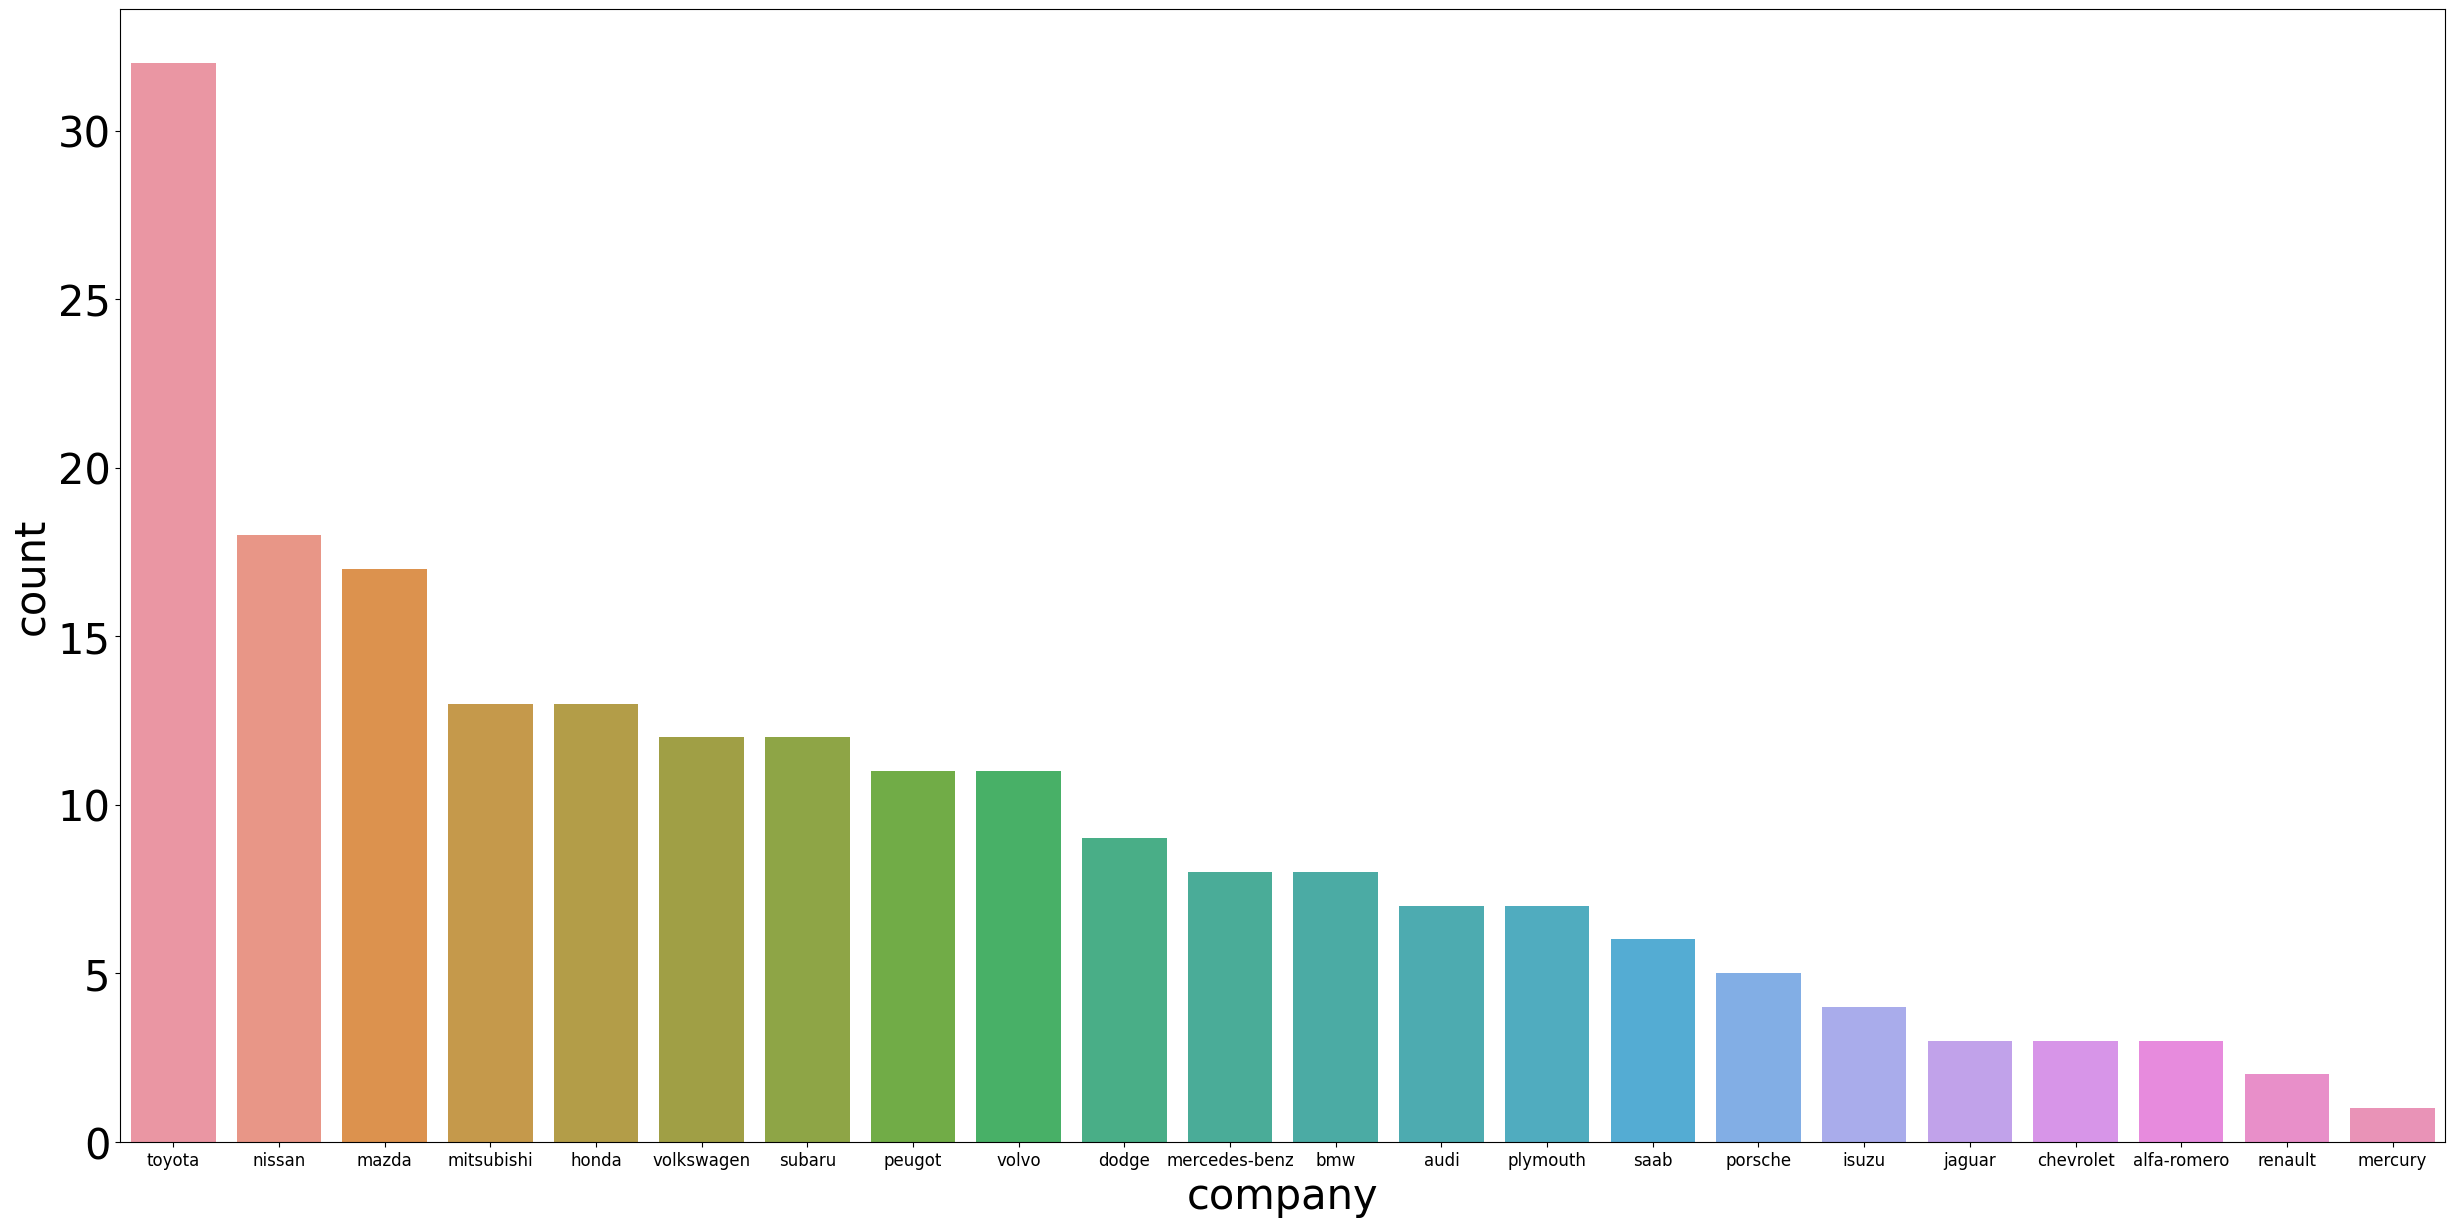

In [20]:
plt.rcParams['figure.figsize'] = (30,15)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams['font.size'] = 30
sns.countplot(x=data['company'],data=data,order=data['company'].value_counts().index)

In [21]:
data['company'].value_counts()

toyota           32
nissan           18
mazda            17
mitsubishi       13
honda            13
volkswagen       12
subaru           12
peugot           11
volvo            11
dodge             9
mercedes-benz     8
bmw               8
audi              7
plymouth          7
saab              6
porsche           5
isuzu             4
jaguar            3
chevrolet         3
alfa-romero       3
renault           2
mercury           1
Name: company, dtype: int64

### observation :

toyota has the largest number of car models in the market. but having most number of car models doesn't necessarily prove that the same company will have most of the market share.



<AxesSubplot:xlabel='company', ylabel='price'>

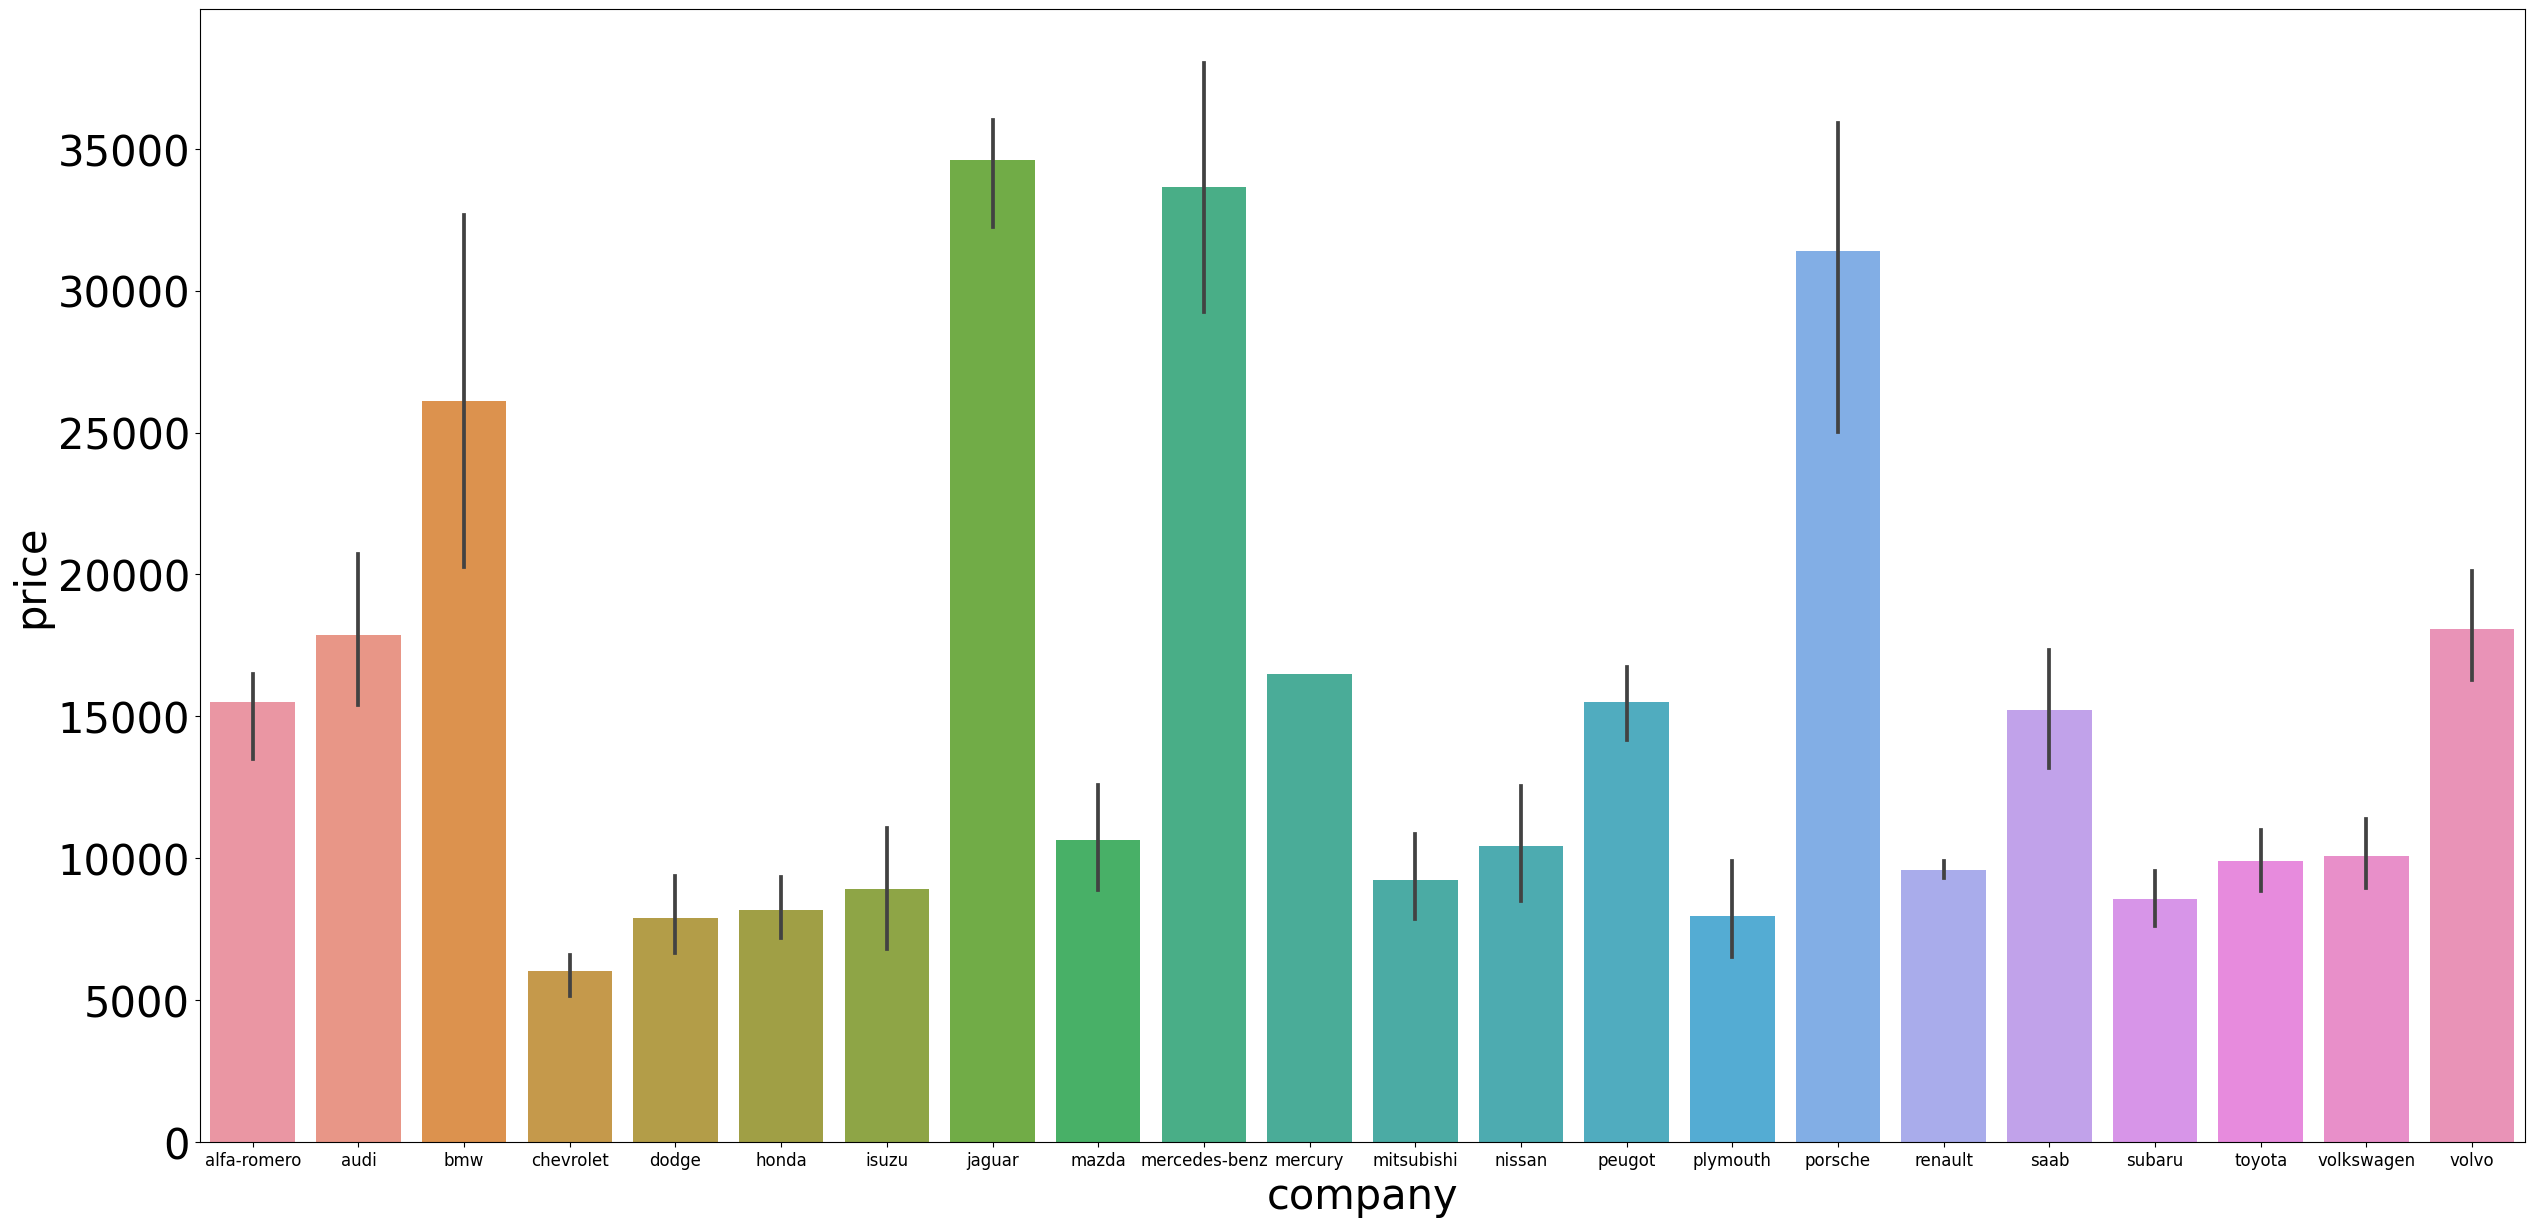

In [22]:
sns.barplot(x=data['company'],y=data['price'])

In [23]:
lines = '''

select data.company, data.price from data where data.price is not null order by data.price desc


'''

sql.sqldf(lines).loc[:15]

,company,price
0,mercedes-benz,45400.0
1,bmw,41315.0
2,mercedes-benz,40960.0
3,porsche,37028.0
4,bmw,36880.0
5,jaguar,36000.0
6,jaguar,35550.0
7,mercedes-benz,35056.0
8,mercedes-benz,34184.0
9,porsche,34028.0


In [24]:
sql.sqldf(lines).iloc[-15:,:]

,company,price
186,toyota,6338.0
187,chevrolet,6295.0
188,dodge,6229.0
189,plymouth,6229.0
190,mitsubishi,6189.0
191,mazda,6095.0
192,dodge,5572.0
193,plymouth,5572.0
194,nissan,5499.0
195,honda,5399.0


mercedes-benz, bmw, porsche, jaguar have by far the most valued cars in the market. on the contrary subaru, chevrolet, mazda, toyota etc are on the lower end of the price.

<AxesSubplot:xlabel='company', ylabel='symboling'>

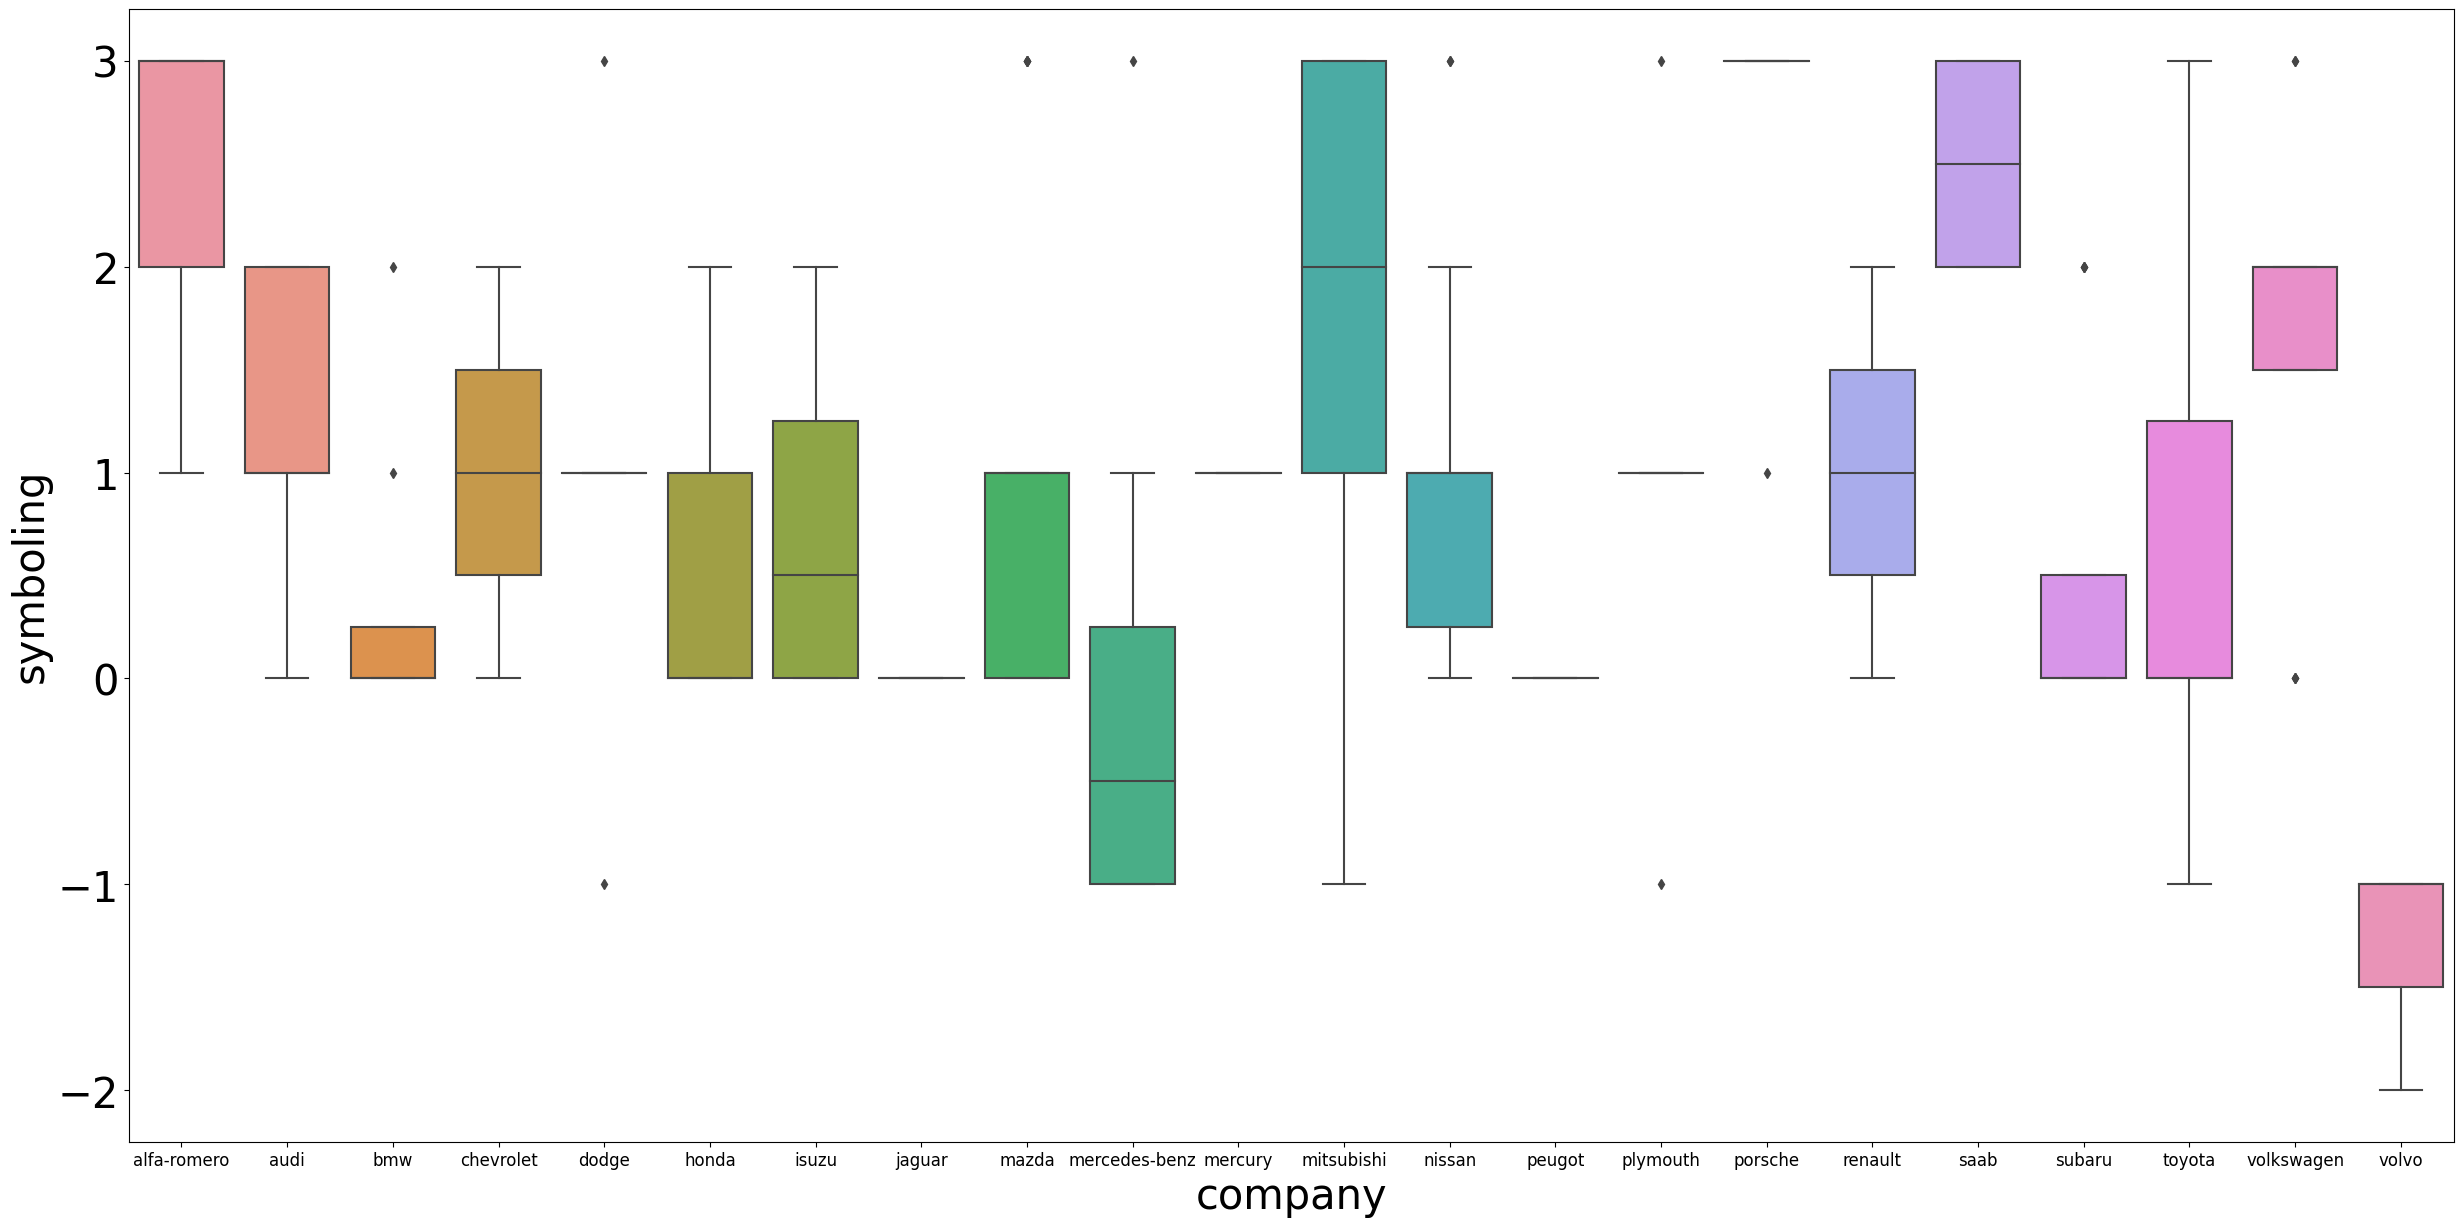

In [25]:
sns.boxplot(x=data['company'], y = data['symboling'])

In [26]:
lines = '''

select data.company, avg(data.symboling) as avarage_symboling, 
min(data.symboling) as most_safe,
max(data.symboling) as least_safe,
count(data.symboling) as model_count,
round(avg(data.price),1) as avarage_price
from data
group by data.company order by avarage_symboling

'''

print("Less is better")
sql.sqldf(lines)

Less is better


,company,avarage_symboling,most_safe,least_safe,model_count,avarage_price
0,volvo,-1.272727,-2,-1,11,18063.2
1,jaguar,0.000000,0,0,3,34600.0
2,mercedes-benz,0.000000,-1,3,8,33647.0
3,peugot,0.000000,0,0,11,15489.1
4,bmw,0.375000,0,2,8,26118.8
5,subaru,0.500000,0,2,12,8541.3
6,toyota,0.562500,-1,3,32,9885.8
7,honda,0.615385,0,2,13,8184.7
8,isuzu,0.750000,0,2,4,8916.5
9,chevrolet,1.000000,0,2,3,6007.0


<AxesSubplot:xlabel='symboling', ylabel='price'>

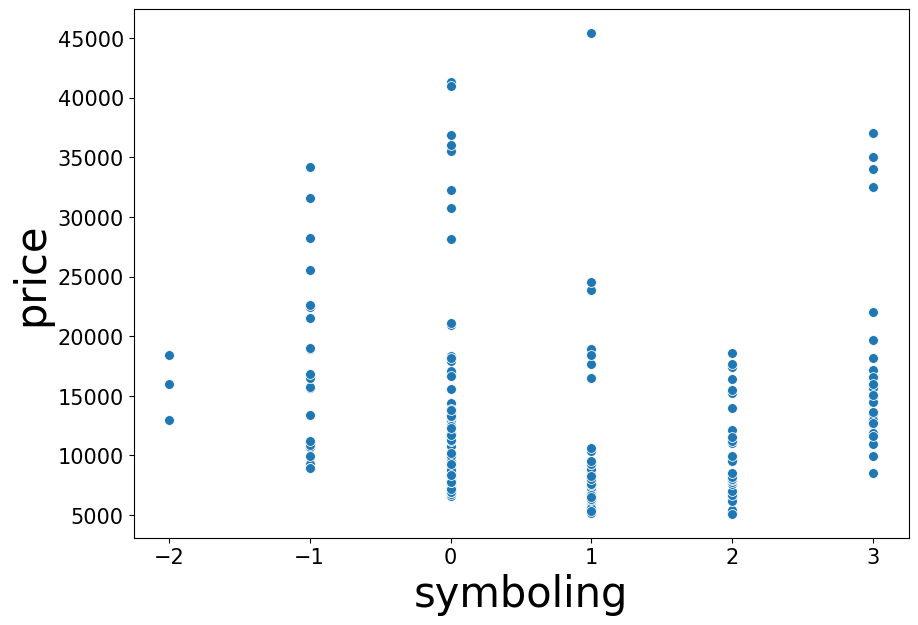

In [27]:
plt.rcParams['figure.figsize'] = (10,7)
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['font.size'] = 30

sns.scatterplot(data=data,x='symboling',y='price',s=50)


### obsevations
<br>

<font size = 3>
    Volvo has one of the safest car models even though the avarage car model cost is 18,000\$,
    on the other
    hand Porsche has the least safeest car yet its avarage car model cost is 31,400\$. 
    Chevrolet has the cheapest avarage car models,6007$ and it is not that safe.
    
<br>

comparing the price and symboling data it is clearly visible that the safety of a car model does not correspond to its price.

<font/>

<AxesSubplot:xlabel='company', ylabel='normalized_losses'>

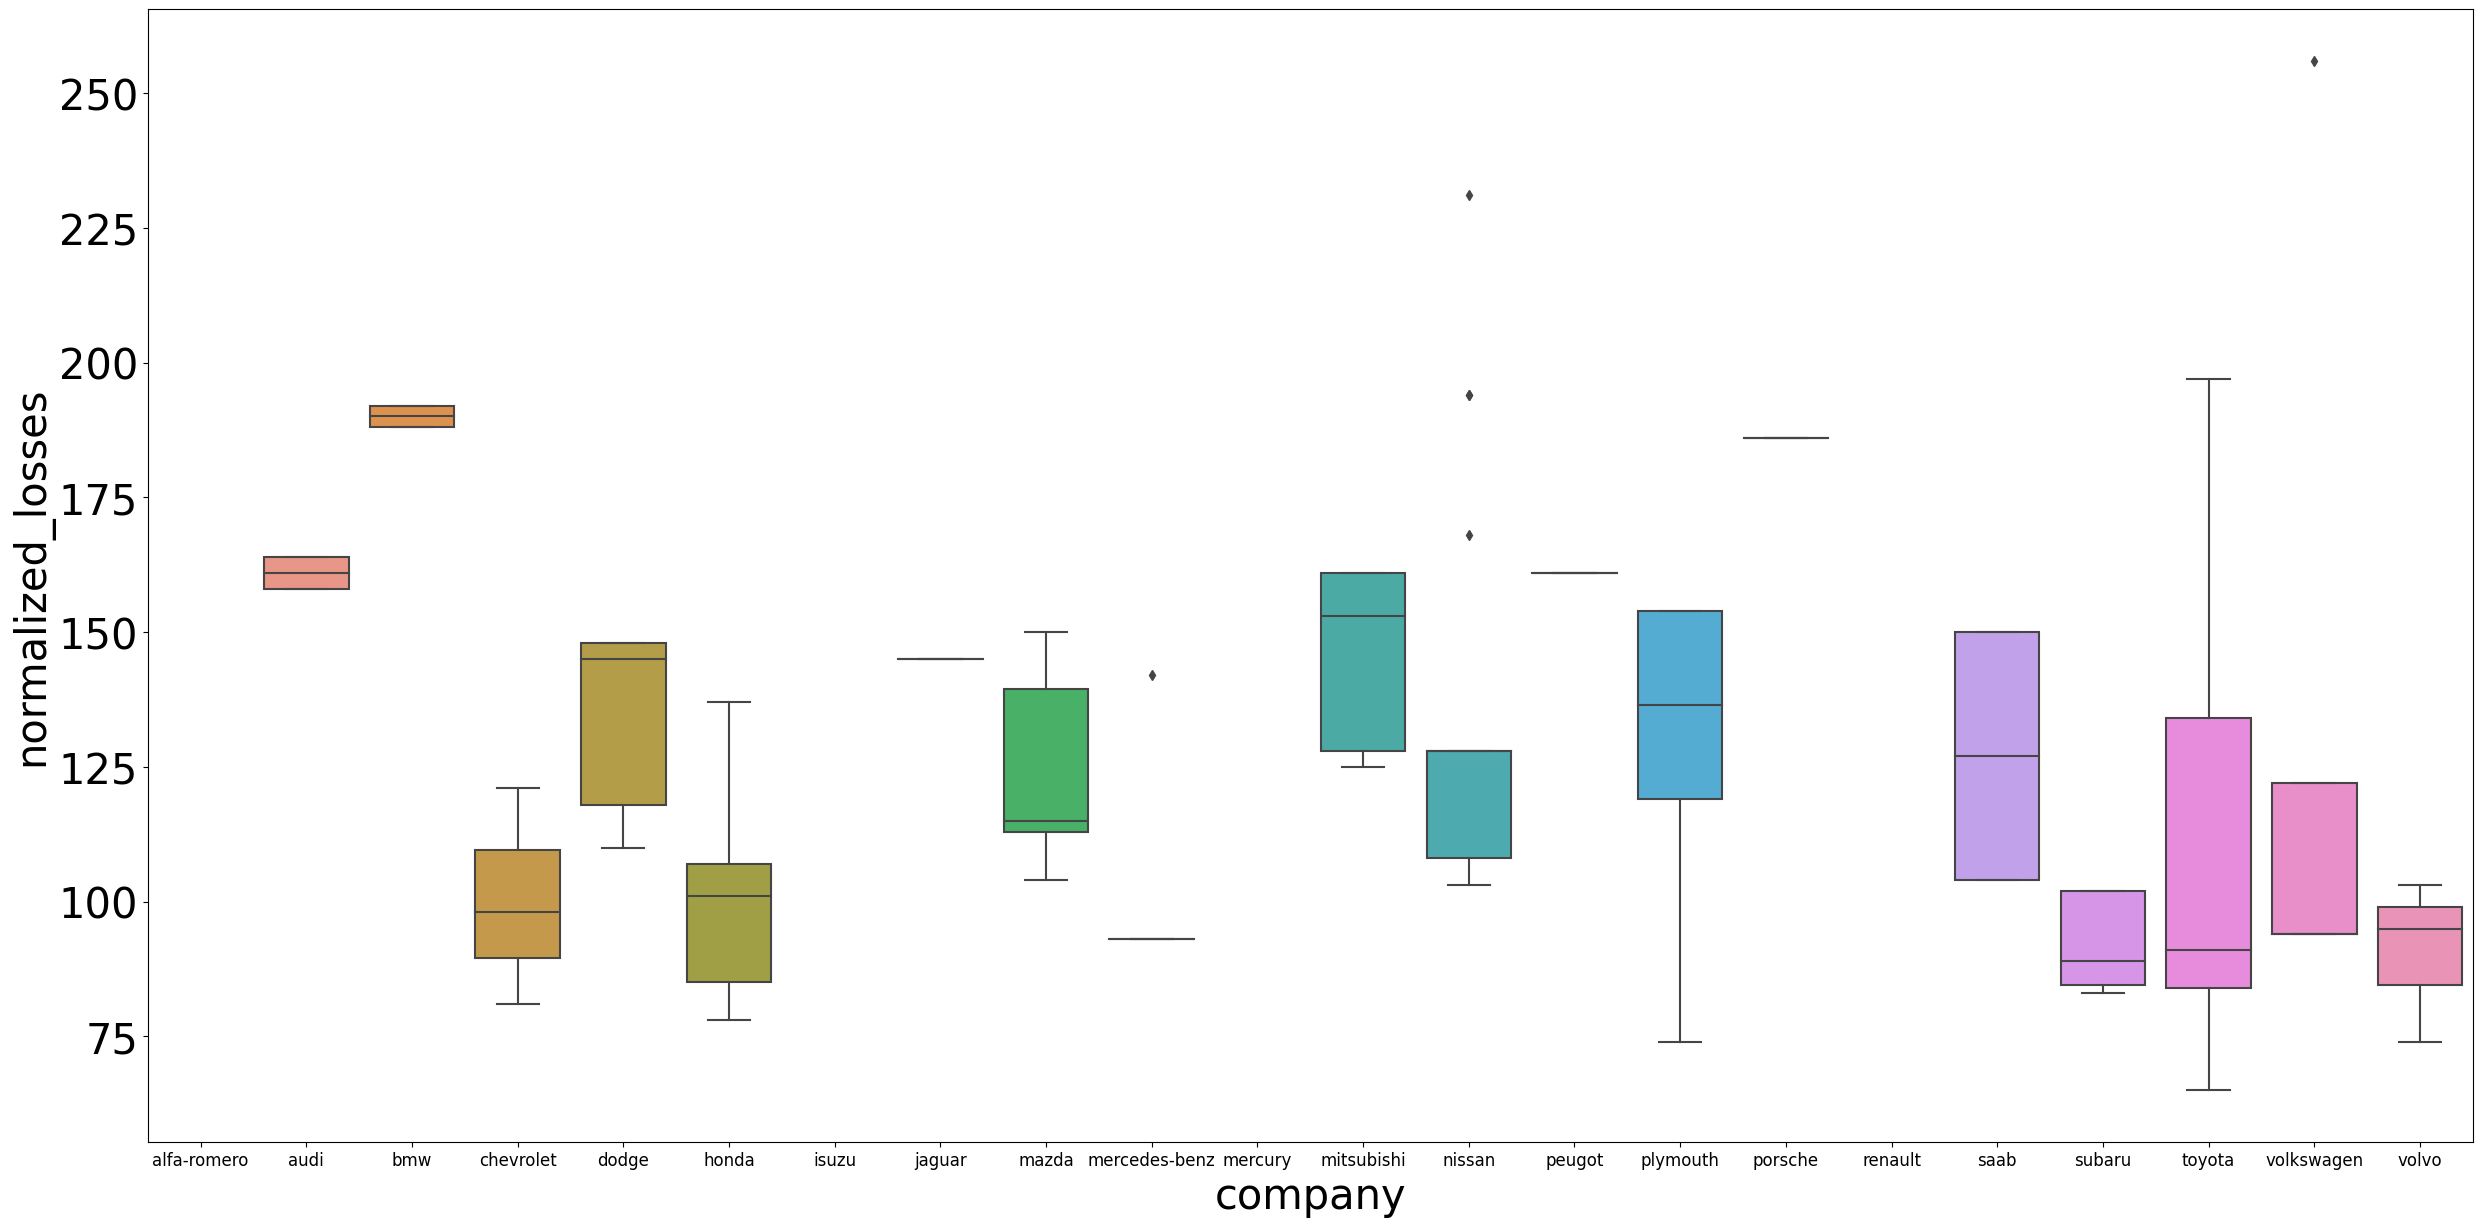

In [28]:
plt.rcParams['figure.figsize'] = (30,15)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams['font.size'] = 30
sns.boxplot(x=data['company'], y = data['normalized_losses'])

In [29]:
lines = '''

select data.company, avg(data.normalized_losses) as avarage_normalized_losses, 
min(data.normalized_losses) as minimum_normalized_losses,
max(data.normalized_losses) as maximum_normalized_losses,
count(data.normalized_losses) as model_count,
round(avg(data.price),1) as avarage_price
from data
where data.normalized_losses is not null
group by data.company order by avarage_normalized_losses asc

'''


nor_loss = sql.sqldf(lines)
nor_loss

,company,avarage_normalized_losses,minimum_normalized_losses,maximum_normalized_losses,model_count,avarage_price
0,volvo,91.454545,74.0,103.0,11,18063.2
1,subaru,92.250000,83.0,102.0,12,8541.3
2,chevrolet,100.000000,81.0,121.0,3,6007.0
3,mercedes-benz,102.800000,93.0,142.0,5,29726.4
4,honda,103.000000,78.0,137.0,13,8184.7
5,toyota,110.290323,65.0,197.0,31,9696.6
6,volkswagen,121.250000,94.0,256.0,8,8738.1
7,mazda,123.933333,104.0,150.0,15,10130.7
8,saab,127.000000,104.0,150.0,6,15223.3
9,plymouth,129.000000,74.0,154.0,6,7163.3


<AxesSubplot:xlabel='model_count', ylabel='avarage_normalized_losses'>

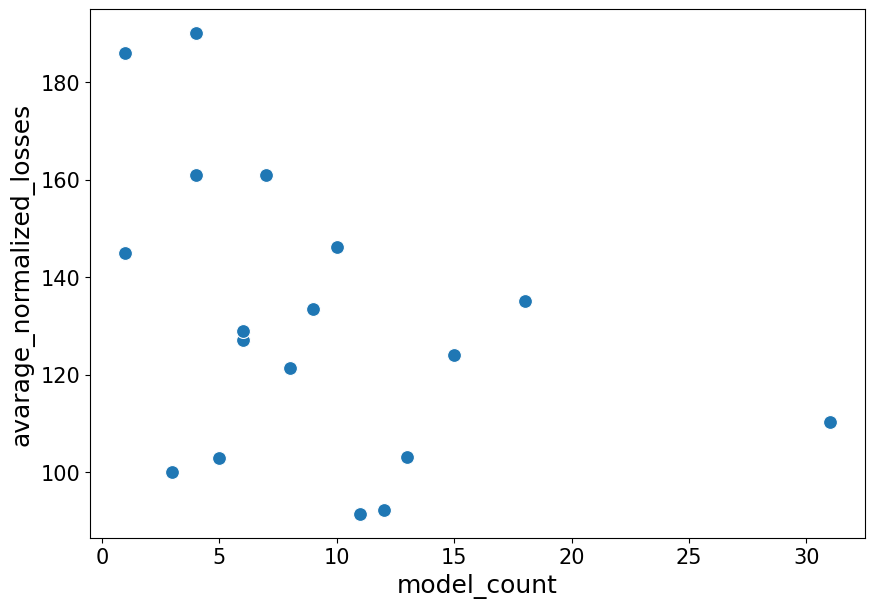

In [30]:
plt.rcParams['figure.figsize'] = (10,7)
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['font.size'] = 18
sns.scatterplot(data=nor_loss,x='model_count',y='avarage_normalized_losses',s=100)

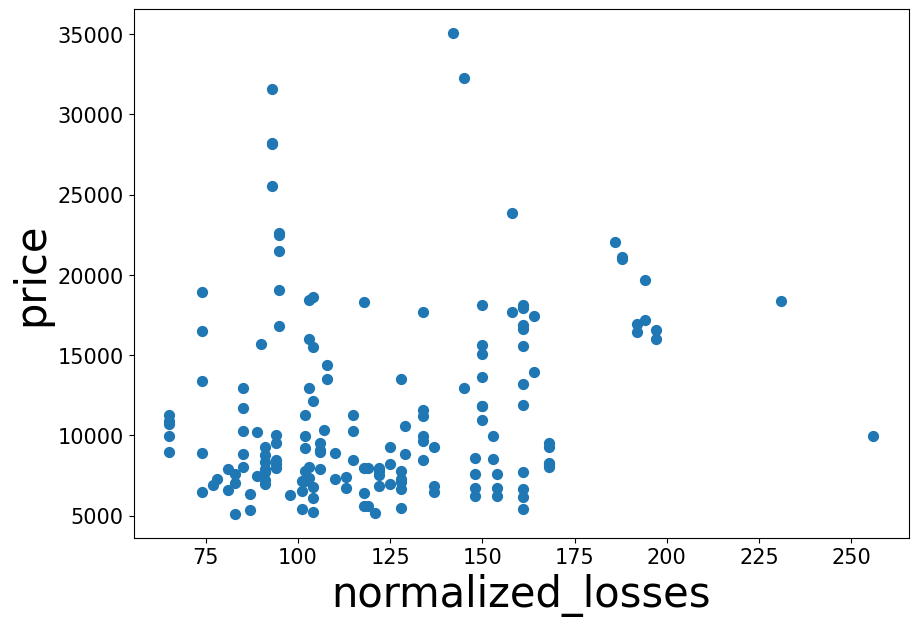

In [31]:
plt.rcParams['figure.figsize'] = (10,7)
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['font.size'] = 30
plt.xlabel('normalized_losses')
plt.ylabel('price')
plt.scatter(data['normalized_losses'],data['price'],s=50)


In [32]:
corelate = data.corr('spearman')
corelate['normalized_losses']

symboling            0.527040
normalized_losses    1.000000
wheel_base          -0.107533
length               0.020539
width                0.114213
height              -0.391902
curb_weight          0.085896
engine_size          0.081360
bore                -0.063747
stroke               0.092518
compression_ratio   -0.051242
horsepower           0.238695
peak_rpm             0.298279
city_mpg            -0.253458
highway_mpg         -0.196705
price                0.187942
Name: normalized_losses, dtype: float64

In [33]:
data['normalized_losses'].describe()

count    164.000000
mean     122.000000
std       35.442168
min       65.000000
25%       94.000000
50%      115.000000
75%      150.000000
max      256.000000
Name: normalized_losses, dtype: float64

### obsevations
<br>

<font size = 3>
        
prices do not much affect the normalized losses of insurance. this is primaraly indicated by the fact that between range of 75 to 100 of normalized losses the price of a car ranges from 5,000\\$ to 30,000\$    
<br>
although there is some correlationship between number of models manufacured and normalized losses.

<font/>

<AxesSubplot:xlabel='Fuel_type', ylabel='price'>

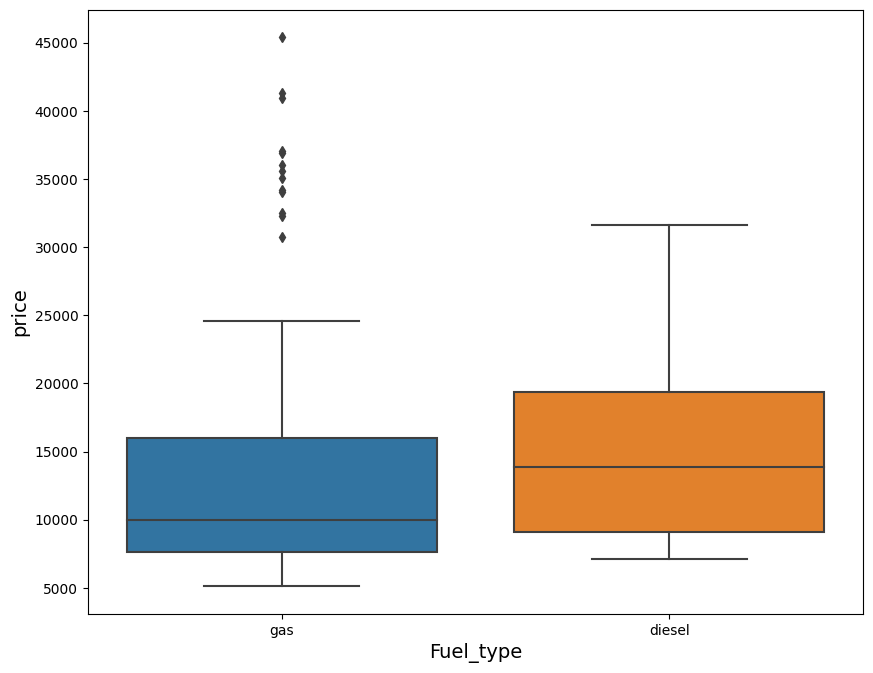

In [34]:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.size'] = 14
sns.boxplot(x=data['Fuel_type'], y = data['price'])

### observations

dissel car models, on avarage, cost more than the gas (petrol) cars

<AxesSubplot:xlabel='num_doors', ylabel='horsepower'>

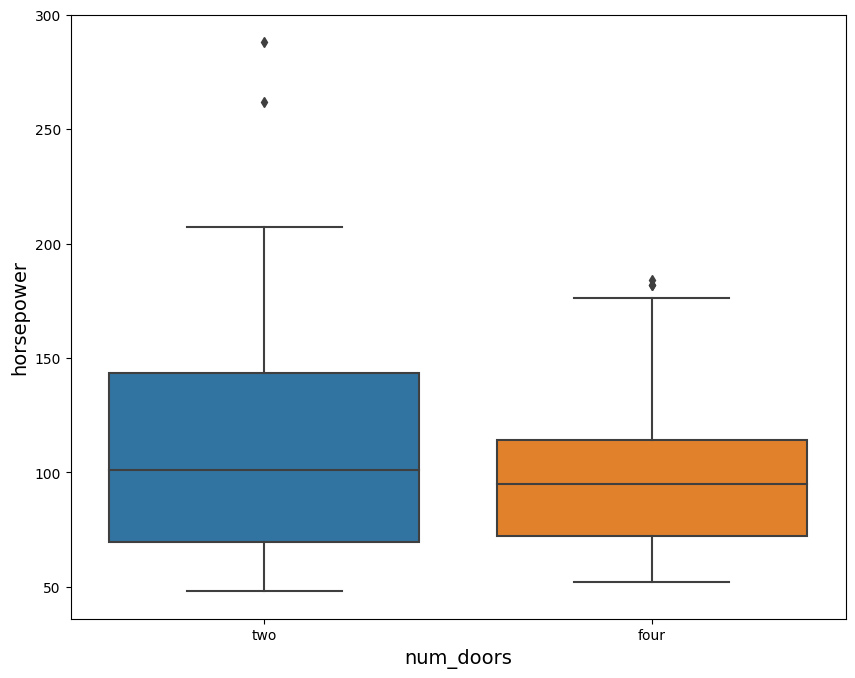

In [35]:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.size'] = 14
sns.boxplot(x=data['num_doors'], y = data['horsepower'])

<AxesSubplot:xlabel='num_doors', ylabel='price'>

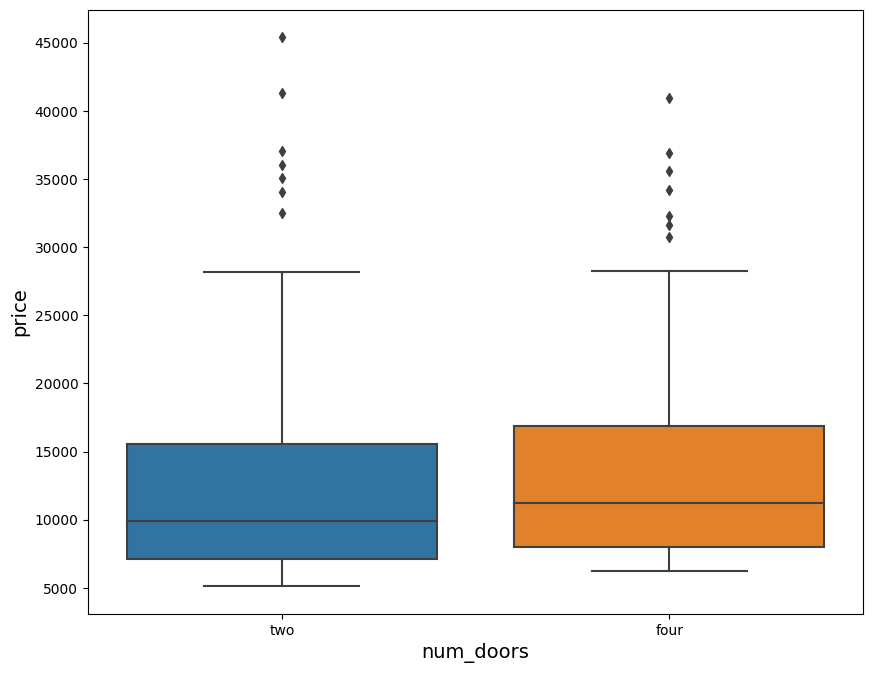

In [36]:
sns.boxplot(data=data,x='num_doors',y='price')

<AxesSubplot:xlabel='num_doors', ylabel='engine_size'>

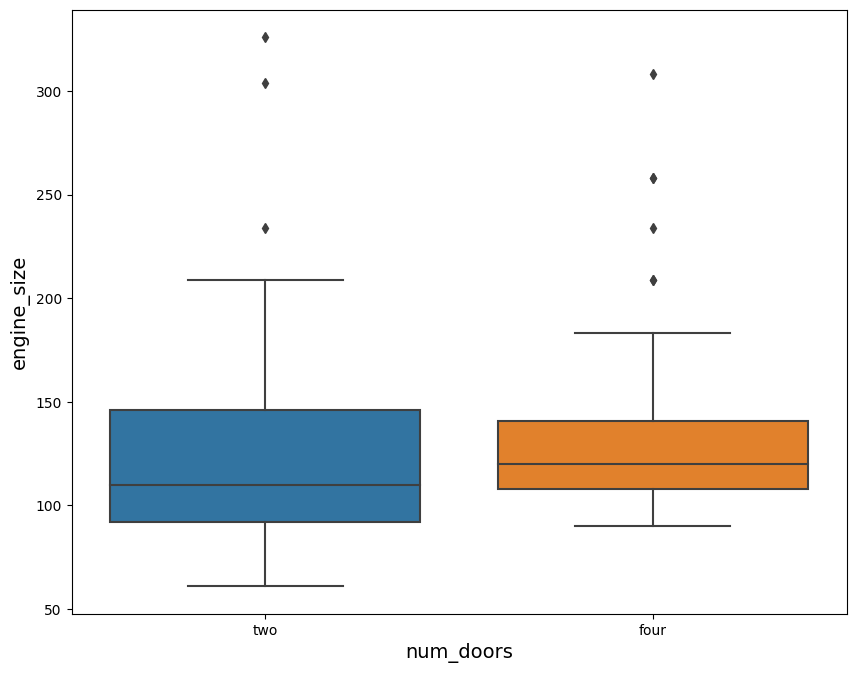

In [37]:
sns.boxplot(data=data,x='num_doors',y='engine_size',)

### observations
<br>

<font size = 3>
the price difference between two and four doors car isn't that appearant. what is more visible is that, presumably there are two kinds of two door cars: first, which is made for the lower segment of the market with lower horsepower. second, which is made for the higher segment with higher horsepower.
<br>

as we can see in the engine size of the both types of cars, where four door cars are neither high-powered nor low-powered, on the other hand the two door cars fill mojority of the spectrum of the engine size.

<AxesSubplot:xlabel='horsepower', ylabel='price'>

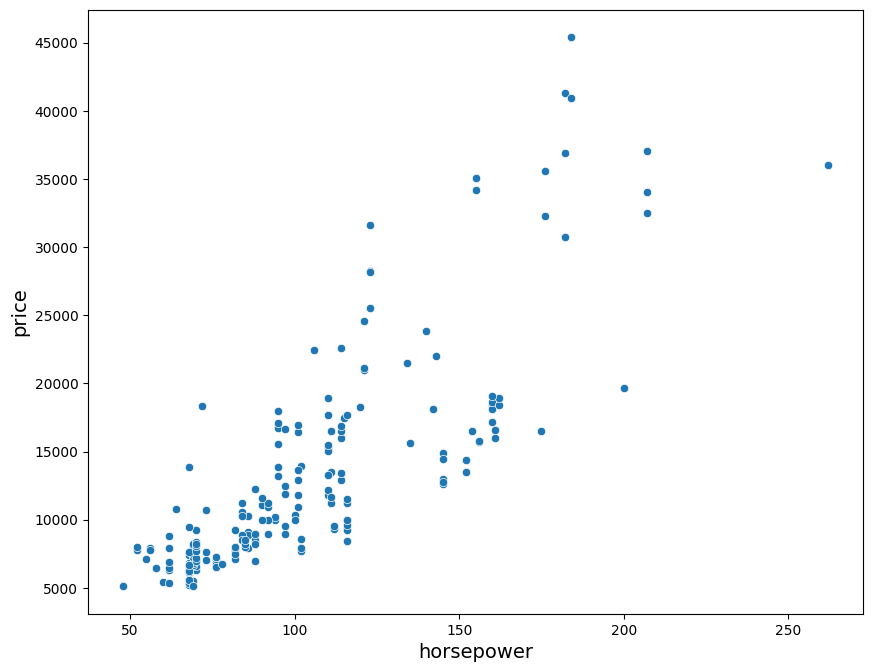

In [38]:
sns.scatterplot(data=data,x='horsepower',y='price')

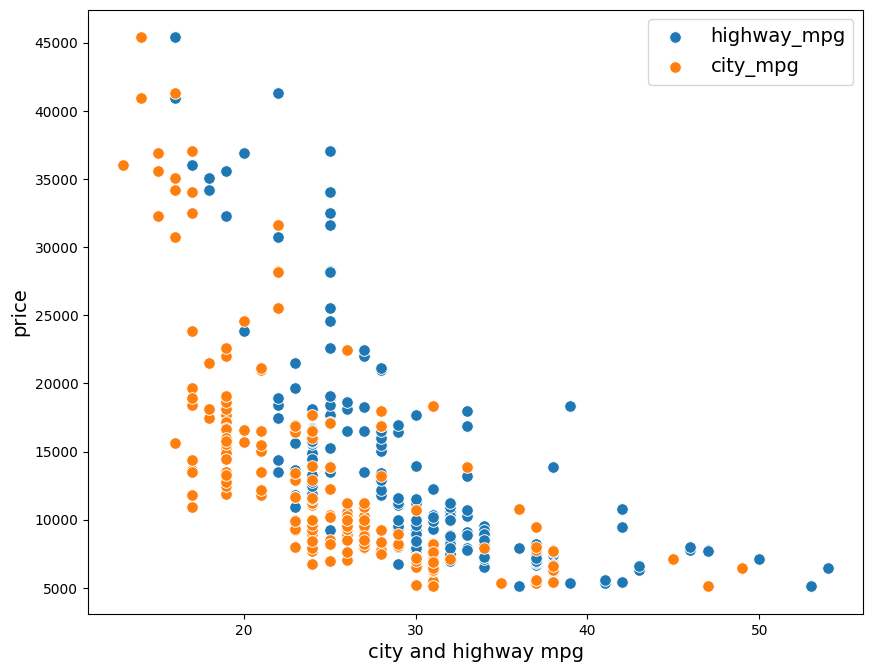

In [39]:
fig,ax = plt.subplots()
for i in ['highway_mpg','city_mpg']:
    sns.scatterplot(data=data,x=i,y='price',label=i,s=70)
    ax.plot()
    ax.legend()
    ax.set_xlabel('city and highway mpg')

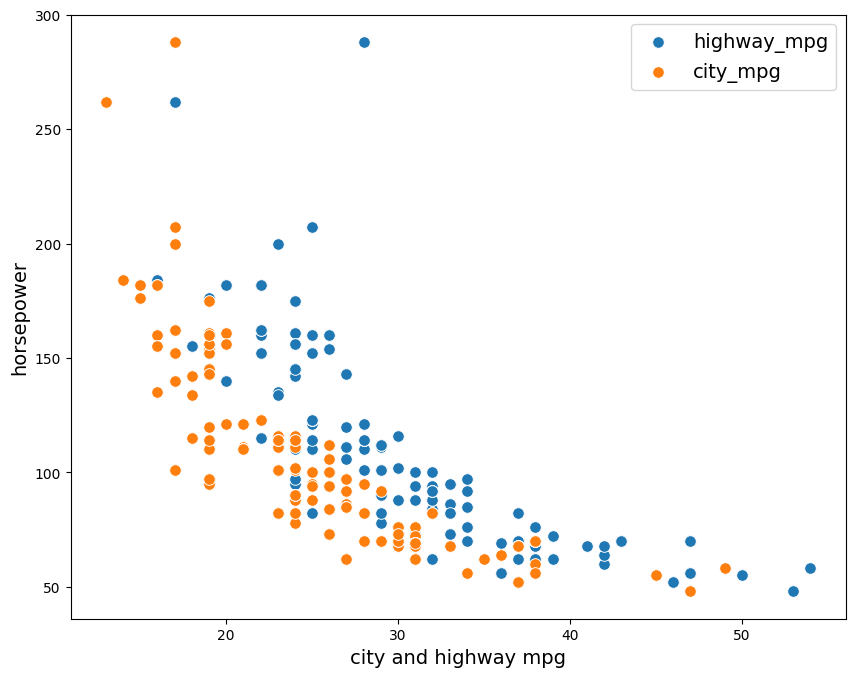

In [40]:
fig,ax = plt.subplots()
for i in ['highway_mpg','city_mpg']:
    sns.scatterplot(data=data,x=i,y='horsepower',label=i,s=70)
    ax.plot()
    ax.legend()
    ax.set_xlabel('city and highway mpg')

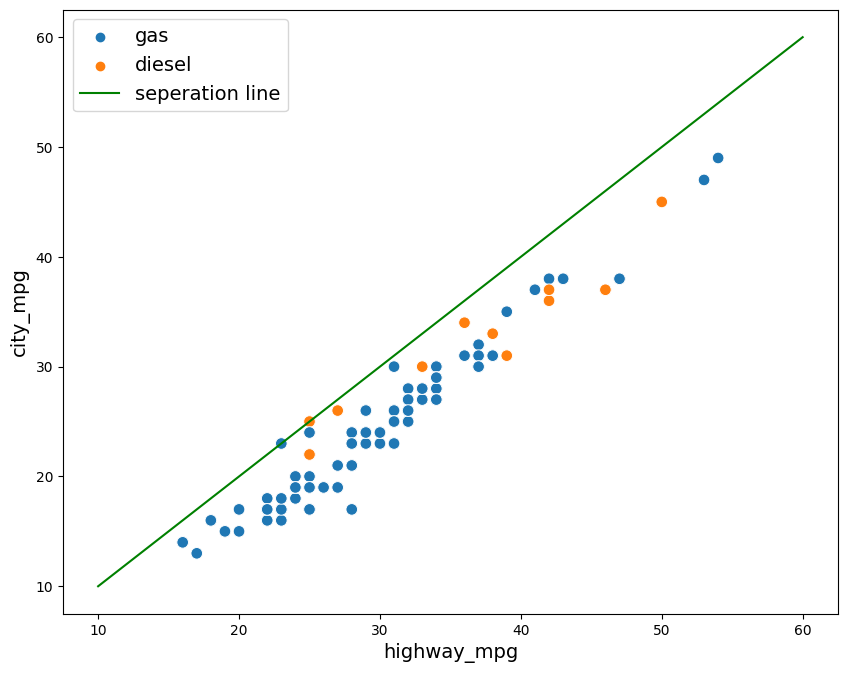

In [41]:
sns.scatterplot(data=data,x='highway_mpg',y='city_mpg',hue='Fuel_type',s=70)
plt.plot([10,60],[10,60],c='green',label='seperation line') 
plt.legend()

### observations

<br>

<font size = 3>
1) higher horsepower means higher cost of the car.
<br>
2) cars gives more highway mpg than their city mpg
<br>
3) lower mpg cars cost more and have more horsepower
<br>
4) higher mpg cars cost less and have less horsepower
    
    

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized_losses  164 non-null    float64
 2   company            205 non-null    object 
 3   Fuel_type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num_doors          203 non-null    object 
 6   body_style         205 non-null    object 
 7   drive_wheels       205 non-null    object 
 8   engine_location    205 non-null    object 
 9   wheel_base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb_weight        205 non-null    int64  
 14  engine_type        205 non-null    object 
 15  num_of_cylinders   205 non-null    object 
 16  engine_size        205 non

<AxesSubplot:xlabel='wheel_base', ylabel='curb_weight'>

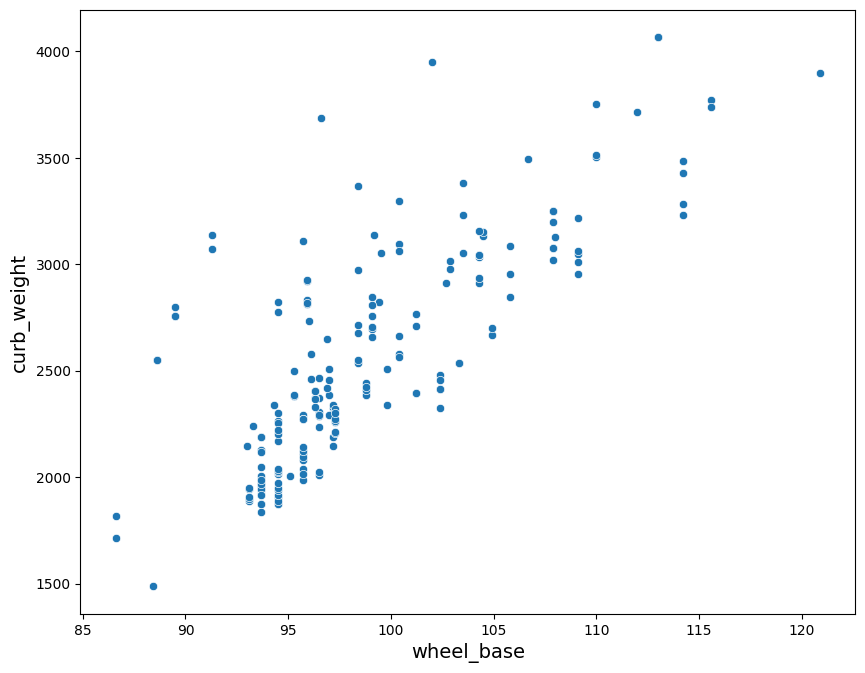

In [43]:
sns.scatterplot(data=data,x='wheel_base',y='curb_weight')

<AxesSubplot:xlabel='wheel_base', ylabel='length'>

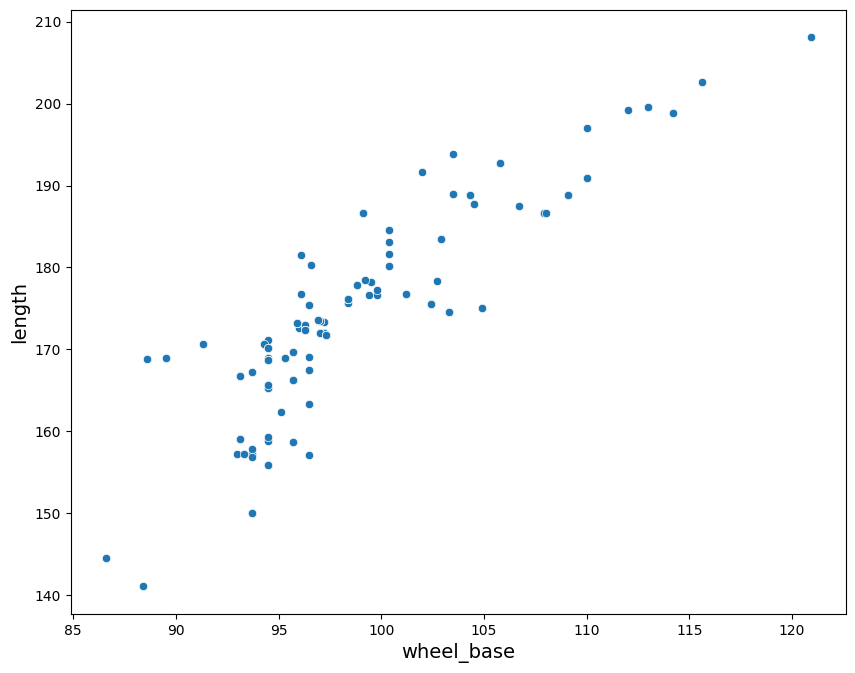

In [44]:
sns.scatterplot(data=data,x='wheel_base',y='length')

In [45]:
def num_cyl(num):
    if num == 'four':
        return 4
    elif num == 'six':
        return 6
    elif num == 'five':
        return 5
    elif num == 'three':
        return 3
    elif num == 'twelve':
        return 12
    elif num == 'two':
        return 2
    elif num == 'eight':
        return 8

In [46]:
cylinders = []

for i in data['num_of_cylinders']:
    cylinders.append(num_cyl(i))

data['num_of_cylinders'] = cylinders
data['num_of_cylinders'].astype(np.float64)
categorical_values.remove('num_of_cylinders')
discrete_values.append('num_of_cylinders')

In [47]:
# data['num_of_cylinders'].replace('four',4,inplace=True)
# data['num_of_cylinders'].replace('six',6,inplace=True)
# data['num_of_cylinders'].replace('five',5,inplace=True)
# data['num_of_cylinders'].replace('three',3,inplace=True)
# data['num_of_cylinders'].replace('twelve',12,inplace=True)
# data['num_of_cylinders'].replace('two',2,inplace=True)
# data['num_of_cylinders'].replace('eight',8,inplace=True)
# data['num_of_cylinders'].astype(np.float64)
# categorical_values.remove('num_of_cylinders')
# discrete_values.append('num_of_cylinders')

<AxesSubplot:xlabel='num_of_cylinders', ylabel='price'>

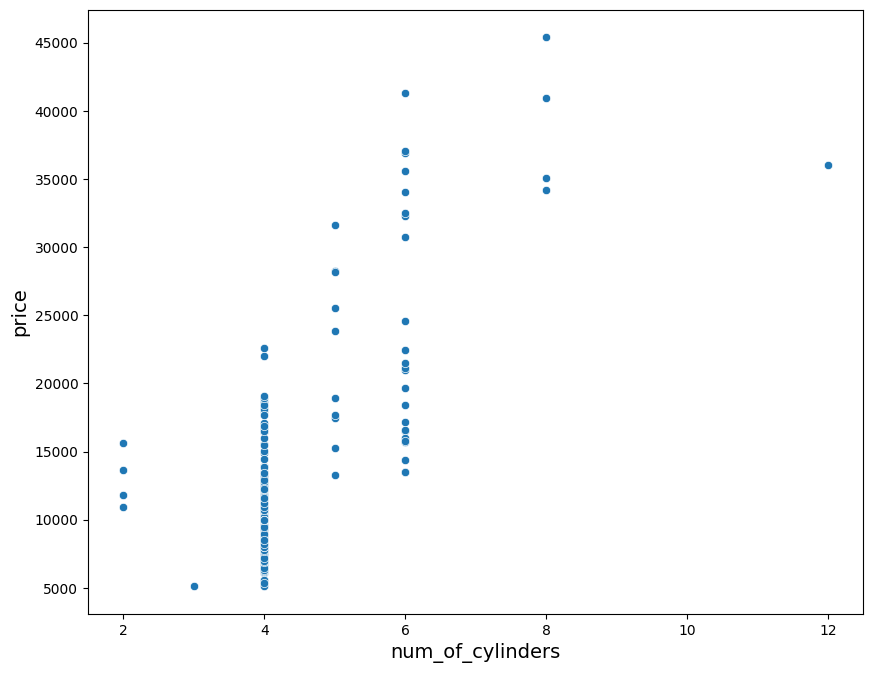

In [48]:
sns.scatterplot(x = data['num_of_cylinders'], y=data['price'])

<AxesSubplot:xlabel='num_of_cylinders', ylabel='horsepower'>

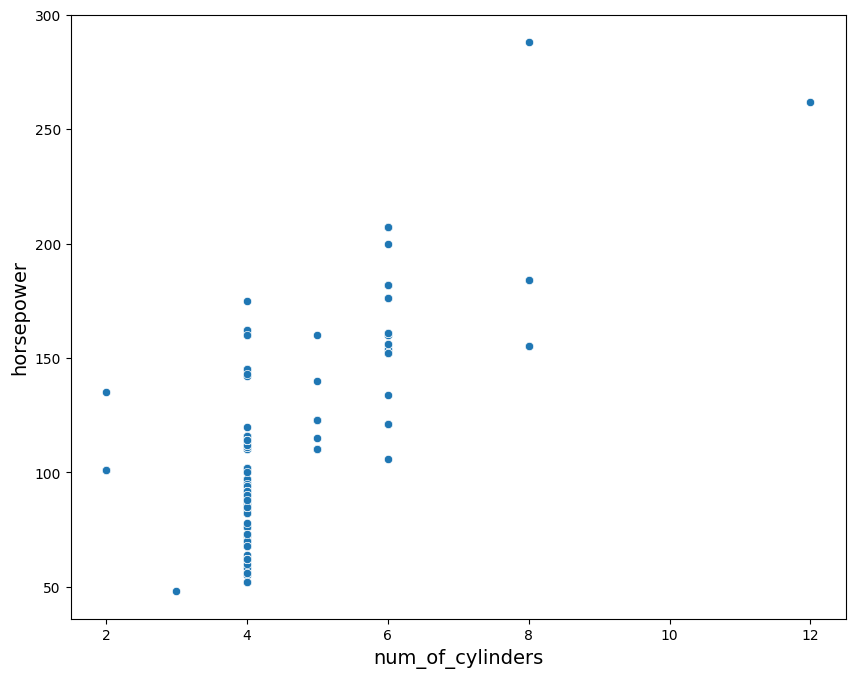

In [49]:
sns.scatterplot(x = data['num_of_cylinders'], y=data['horsepower'])

### observations

<br>

<font size = 3>
1) there is positive correlationship between wheel base and curb weight
<br>
2) there is also positive corelationship between length of a car and wheel base. this is obvious and validated with data that longer the car is, it would physically need a longer wheel base to account for center of gravity and increasing stability.
<br>
3) number of cyclinders, horsepower and cost of a car also positively corelates.

    
    

In [50]:
nan_col = [i for i in data.columns if data[i].isna().mean() > 0]
nan_col

['normalized_losses',
 'num_doors',
 'bore',
 'stroke',
 'horsepower',
 'peak_rpm',
 'price']

In [51]:
for i in nan_col:
    n = 20-len(i)
    if i in discrete_values+categorical_values:
        print('category/discrete :    ',i,' '*n,round(data[i].isna().mean(),2))
        
    else:
        
        print('continuous',' '*6,':    ', i,' '*n,round(data[i].isna().mean(),2))

continuous        :     normalized_losses     0.2
category/discrete :     num_doors             0.01
continuous        :     bore                  0.02
continuous        :     stroke                0.02
continuous        :     horsepower            0.01
continuous        :     peak_rpm              0.01
continuous        :     price                 0.02


In [52]:
for col in nan_col:
    if data[col].dtype == 'O':
        pass
    else:
        data[col].replace(np.nan,data[col].median(),inplace=True)
        
data.dropna(inplace=True)

In [53]:
for i in nan_col:
    n = 20-len(i)
    print(i,' '*n, round(data[i].isna().mean(),2))

normalized_losses     0.0
num_doors             0.0
bore                  0.0
stroke                0.0
horsepower            0.0
peak_rpm              0.0
price                 0.0


### Decision :

Our main Objective is to build a ML model that can predict the car price depending on the various features it has; since the company will be tinkering with their own models through in house R&D, we are in no need to keep the feature 'company' in the dataset. Therefore we are dropping it.

In [54]:
data.drop(columns='company',inplace=True)
categorical_values.remove('company')

## Machine Learning Regression Model using Sklearn

In [55]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


In [56]:
encoder = LabelEncoder()
one_encoder = OneHotEncoder()

In [57]:
compare_col = data.columns
len(data.columns), data.columns

(25,
 Index(['symboling', 'normalized_losses', 'Fuel_type', 'aspiration',
        'num_doors', 'body_style', 'drive_wheels', 'engine_location',
        'wheel_base', 'length', 'width', 'height', 'curb_weight', 'engine_type',
        'num_of_cylinders', 'engine_size', 'fuel_system', 'bore', 'stroke',
        'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg',
        'highway_mpg', 'price'],
       dtype='object'))

In [58]:
class one_hot_encoder_fn():
    
    '''
    data_feed : works like fit in the encoder
    encoder   : should be like OneHotEncoder()
    
    data_transform : works like transform in the encoder
    '''
    def advance_fn(self,one_encoder):
        self.one_encoder = one_encoder
    
    def data_feed(self,data,one_encoder):

        self.one_encoder = one_encoder
        self.one_encoder.fit(data)
    
    def data_transform(self,data,col_name = None):
        if str(self.one_encoder) == 'LabelEncoder()':
            col = self.one_encoder.classes_
            final_table = pd.DataFrame(self.one_encoder.transform(data),columns=[col_name])
        else:
            cols = self.one_encoder.categories_
        
            col = []

            for i in range(len(cols)):
                for ii in cols[i]:
                    col.append(ii)
        

            final_table = pd.DataFrame(self.one_encoder.transform(data).toarray(),columns=col)
        return final_table
    

In [59]:
pd.DataFrame([[1],[2]],columns=['a'])['a']

0    1
1    2
Name: a, dtype: int64

In [60]:
one_enlist = []
for col in categorical_values:
    if len(data[col].unique()) <=5:
        one_enlist.append(col)
one_enlist

['Fuel_type',
 'aspiration',
 'num_doors',
 'body_style',
 'drive_wheels',
 'engine_location']

In [61]:
label_encoded_list = {}

for col in categorical_values:
    if len(data[col].unique()) <=5:
        pass
        
    else:
        data[col] = encoder.fit_transform(data[col])
        label_encoded_list[col] = encoder.classes_

In [62]:
label_encoded_list

{'engine_type': array(['dohc', 'dohcv', 'l', 'ohc', 'ohcf', 'ohcv', 'rotor'], dtype=object),
 'fuel_system': array(['1bbl', '2bbl', '4bbl', 'idi', 'mfi', 'mpfi', 'spdi', 'spfi'],
       dtype=object)}

In [63]:
en_fn = one_hot_encoder_fn()

In [64]:
en_fn.data_feed(data[one_enlist],one_encoder=OneHotEncoder())
new_col = en_fn.data_transform(data[one_enlist])
new_col.head()

,diesel,gas,std,turbo,four,two,convertible,hardtop,hatchback,sedan,wagon,4wd,fwd,rwd,front,rear
0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [65]:
orig_one_encoder = en_fn.one_encoder

In [66]:
data.drop(columns=one_enlist,inplace=True)
data = pd.concat([data,new_col],axis=1)
data.head()

,symboling,normalized_losses,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price,diesel,gas,std,turbo,four,two,convertible,hardtop,hatchback,sedan,wagon,4wd,fwd,rwd,front,rear
0,3.0,115.0,88.6,168.8,64.1,48.8,2548.0,0.0,4.0,130.0,5.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,13495.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,3.0,115.0,88.6,168.8,64.1,48.8,2548.0,0.0,4.0,130.0,5.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,16500.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,1.0,115.0,94.5,171.2,65.5,52.4,2823.0,5.0,6.0,152.0,5.0,2.68,3.47,9.0,154.0,5000.0,19.0,26.0,16500.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,2.0,164.0,99.8,176.6,66.2,54.3,2337.0,3.0,4.0,109.0,5.0,3.19,3.40,10.0,102.0,5500.0,24.0,30.0,13950.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,2.0,164.0,99.4,176.6,66.4,54.3,2824.0,3.0,5.0,136.0,5.0,3.19,3.40,8.0,115.0,5500.0,18.0,22.0,17450.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205 entries, 0 to 63
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          203 non-null    float64
 1   normalized_losses  203 non-null    float64
 2   wheel_base         203 non-null    float64
 3   length             203 non-null    float64
 4   width              203 non-null    float64
 5   height             203 non-null    float64
 6   curb_weight        203 non-null    float64
 7   engine_type        203 non-null    float64
 8   num_of_cylinders   203 non-null    float64
 9   engine_size        203 non-null    float64
 10  fuel_system        203 non-null    float64
 11  bore               203 non-null    float64
 12  stroke             203 non-null    float64
 13  compression_ratio  203 non-null    float64
 14  horsepower         203 non-null    float64
 15  peak_rpm           203 non-null    float64
 16  city_mpg           203 non-

In [68]:
scaler = StandardScaler()

In [69]:
model_data = data.copy()

In [70]:
len(data.columns)

35

In [71]:
model_data = scaler.fit_transform(model_data)

In [72]:
model_data = pd.DataFrame(model_data,columns=data.columns)
model_data.head()

,symboling,normalized_losses,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price,diesel,gas,std,turbo,four,two,convertible,hardtop,hatchback,sedan,wagon,4wd,fwd,rwd,front,rear
0,1.734298,-0.172600,-1.689532,-0.431672,-0.846292,-2.024019,-0.019023,-2.851234,-0.354839,0.070180,0.870606,0.515226,-1.829797,-0.281853,0.167628,-0.265791,-0.640559,-0.539468,0.039349,-0.321342,0.321342,0.464294,-0.464294,-1.131768,1.131768,5.730038,-0.202548,-0.725476,-0.928647,-0.374766,-0.215387,-1.178234,1.292692,0.122474,-0.122474
1,1.734298,-0.172600,-1.689532,-0.431672,-0.846292,-2.024019,-0.019023,-2.851234,-0.354839,0.070180,0.870606,0.515226,-1.829797,-0.281853,0.167628,-0.265791,-0.640559,-0.539468,0.420205,-0.321342,0.321342,0.464294,-0.464294,-1.131768,1.131768,5.730038,-0.202548,-0.725476,-0.928647,-0.374766,-0.215387,-1.178234,1.292692,0.122474,-0.122474
2,0.130369,-0.172600,-0.710457,-0.236687,-0.193602,-0.546491,0.508536,1.877528,1.492143,0.597834,0.870606,-2.403418,0.685154,-0.281853,1.255527,-0.265791,-0.947604,-0.685290,0.420205,-0.321342,0.321342,0.464294,-0.464294,-1.131768,1.131768,-0.174519,-0.202548,1.378405,-0.928647,-0.374766,-0.215387,-1.178234,1.292692,0.122474,-0.122474
3,0.932333,1.367181,0.169051,0.202028,0.132743,0.233315,-0.423805,-0.013977,-0.354839,-0.433489,0.870606,-0.519230,0.462311,-0.024030,-0.060072,0.783928,-0.179992,-0.102003,0.097016,-0.321342,0.321342,0.464294,-0.464294,0.883573,-0.883573,-0.174519,-0.202548,-0.725476,1.076835,-0.374766,-0.215387,0.848728,-0.773579,0.122474,-0.122474
4,0.932333,1.367181,0.102673,0.202028,0.225984,0.233315,0.510454,-0.013977,0.568652,0.214086,0.870606,-0.519230,0.462311,-0.539676,0.268828,0.783928,-1.101126,-1.268577,0.540609,-0.321342,0.321342,0.464294,-0.464294,0.883573,-0.883573,-0.174519,-0.202548,-0.725476,1.076835,-0.374766,4.642796,-1.178234,-0.773579,0.122474,-0.122474


In [73]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          203 non-null    float64
 1   normalized_losses  203 non-null    float64
 2   wheel_base         203 non-null    float64
 3   length             203 non-null    float64
 4   width              203 non-null    float64
 5   height             203 non-null    float64
 6   curb_weight        203 non-null    float64
 7   engine_type        203 non-null    float64
 8   num_of_cylinders   203 non-null    float64
 9   engine_size        203 non-null    float64
 10  fuel_system        203 non-null    float64
 11  bore               203 non-null    float64
 12  stroke             203 non-null    float64
 13  compression_ratio  203 non-null    float64
 14  horsepower         203 non-null    float64
 15  peak_rpm           203 non-null    float64
 16  city_mpg           203 non

In [74]:
for i in model_data.columns:
    n = 20 - len(i)
    print(i,' '*n, model_data[i].isna().mean())

symboling             0.00975609756097561
normalized_losses     0.00975609756097561
wheel_base            0.00975609756097561
length                0.00975609756097561
width                 0.00975609756097561
height                0.00975609756097561
curb_weight           0.00975609756097561
engine_type           0.00975609756097561
num_of_cylinders      0.00975609756097561
engine_size           0.00975609756097561
fuel_system           0.00975609756097561
bore                  0.00975609756097561
stroke                0.00975609756097561
compression_ratio     0.00975609756097561
horsepower            0.00975609756097561
peak_rpm              0.00975609756097561
city_mpg              0.00975609756097561
highway_mpg           0.00975609756097561
price                 0.00975609756097561
diesel                0.00975609756097561
gas                   0.00975609756097561
std                   0.00975609756097561
turbo                 0.00975609756097561
four                  0.0097560975

In [75]:
len(model_data)

205

In [76]:
model_data.dropna(inplace=True)

In [77]:
len(model_data)

201

In [78]:
x = [i for i in data.columns if i not in ['price']]
y = ['price']

In [79]:
models = [LinearRegression(), SVR(kernel='linear'), SVR(kernel='poly'),RandomForestRegressor()]


for regression in models:
    m = []
    s = []
    print(regression)
    for i in range(10):
        X_train,X_test, y_train,y_test = train_test_split(model_data[x],model_data[y],test_size=0.2)

        regression.fit(X_train,y_train.values.ravel())        
        
        mod = regression.score(X_train,y_train.values.ravel())
        score = regression.score(X_test,y_test.values.ravel())
        m.append(mod)
        s.append(score)
        
        print('epoch ',i)
        print('model : ',mod)
        print('score :',score)
        print('\n')
    
    print(regression,' : ', 'model mean :',np.mean(m),'test mean : ', np.mean(s))
    print('\n\n\n')

LinearRegression()
epoch  0
model :  0.8729442052092042
score : 0.6179787696829688


epoch  1
model :  0.8460662275545652
score : 0.8093421496379247


epoch  2
model :  0.8331302470960888
score : 0.8390816727808762


epoch  3
model :  0.885221651263592
score : 0.3039340796545995


epoch  4
model :  0.8638050142644312
score : 0.6545492945667838


epoch  5
model :  0.8339221574868614
score : 0.801531496970516


epoch  6
model :  0.8525764829586555
score : 0.7501135399462605


epoch  7
model :  0.8664489435540947
score : 0.6985938074455802


epoch  8
model :  0.8489049348704127
score : 0.6958246891417457


epoch  9
model :  0.8537886654280045
score : 0.7712593272453032


LinearRegression()  :  model mean : 0.855680852968591 test mean :  0.6942208827072559




SVR(kernel='linear')
epoch  0
model :  0.829587750625171
score : 0.7627674302288


epoch  1
model :  0.8147798061427938
score : 0.7957125339402151


epoch  2
model :  0.8279080307153229
score : 0.7780680022707592


epoch  3
model :  

<font size = 4> 
    The Random Forest Regression works the best for our dataset as it gives a higher probability of being correct about the price.
<font/>

In [80]:
regression

RandomForestRegressor()

## creating interactive widgets for getting regression prediction of the car value

In [81]:
import ipywidgets as widgets

In [82]:
print('widget_dict = {}\n\n')

for i in categorical_values:
    print(f'''{i} = widgets.Dropdown(
        options= list(result_data['{i}'].unique()),
        value=list(result_data['{i}'].unique())[0],
        description='{i} :',
        disabled=False
    )
widget_dict['{i}'] = {i}

    ''')
    
for i in discrete_values:
    print(f'''{i} = widgets.Dropdown(
        options= list(result_data['{i}'].unique()),
        value=list(result_data['{i}'].unique())[0],
        description='{i} :',
        disabled=False
    )

widget_dict['{i}'] = {i}
    ''')


print('# ----------------------------------------------------------------')


for i in continuous_values:
    print(
        f'''
{i} = widgets.FloatSlider(
    value={np.min(data[i])},
    min={np.min(data[i])},
    max={np.max(data[i])},
    step=0.1,
    description='{i}:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',)
    
widget_dict['{i}'] = {i}

        '''    
    
    )

widget_dict = {}


Fuel_type = widgets.Dropdown(
        options= list(result_data['Fuel_type'].unique()),
        value=list(result_data['Fuel_type'].unique())[0],
        description='Fuel_type :',
        disabled=False
    )
widget_dict['Fuel_type'] = Fuel_type

    
aspiration = widgets.Dropdown(
        options= list(result_data['aspiration'].unique()),
        value=list(result_data['aspiration'].unique())[0],
        description='aspiration :',
        disabled=False
    )
widget_dict['aspiration'] = aspiration

    
num_doors = widgets.Dropdown(
        options= list(result_data['num_doors'].unique()),
        value=list(result_data['num_doors'].unique())[0],
        description='num_doors :',
        disabled=False
    )
widget_dict['num_doors'] = num_doors

    
body_style = widgets.Dropdown(
        options= list(result_data['body_style'].unique()),
        value=list(result_data['body_style'].unique())[0],
        description='body_style :',
        disabled=False
    )
wi

In [83]:
widget_dict = {}


Fuel_type = widgets.Dropdown(
        options= list(result_data['Fuel_type'].unique()),
        value=list(result_data['Fuel_type'].unique())[0],
        description='Fuel_type :',
        disabled=False
    )
widget_dict['Fuel_type'] = Fuel_type

    
aspiration = widgets.Dropdown(
        options= list(result_data['aspiration'].unique()),
        value=list(result_data['aspiration'].unique())[0],
        description='aspiration :',
        disabled=False
    )
widget_dict['aspiration'] = aspiration

    
num_doors = widgets.Dropdown(
        options= list(result_data['num_doors'].unique()),
        value=list(result_data['num_doors'].unique())[0],
        description='num_doors :',
        disabled=False
    )
widget_dict['num_doors'] = num_doors

    
body_style = widgets.Dropdown(
        options= list(result_data['body_style'].unique()),
        value=list(result_data['body_style'].unique())[0],
        description='body_style :',
        disabled=False
    )
widget_dict['body_style'] = body_style

    
drive_wheels = widgets.Dropdown(
        options= list(result_data['drive_wheels'].unique()),
        value=list(result_data['drive_wheels'].unique())[0],
        description='drive_wheels :',
        disabled=False
    )
widget_dict['drive_wheels'] = drive_wheels

    
engine_location = widgets.Dropdown(
        options= list(result_data['engine_location'].unique()),
        value=list(result_data['engine_location'].unique())[0],
        description='engine_location :',
        disabled=False
    )
widget_dict['engine_location'] = engine_location

    
engine_type = widgets.Dropdown(
        options= list(result_data['engine_type'].unique()),
        value=list(result_data['engine_type'].unique())[0],
        description='engine_type :',
        disabled=False
    )
widget_dict['engine_type'] = engine_type

    
fuel_system = widgets.Dropdown(
        options= list(result_data['fuel_system'].unique()),
        value=list(result_data['fuel_system'].unique())[0],
        description='fuel_system :',
        disabled=False
    )
widget_dict['fuel_system'] = fuel_system

    
symboling = widgets.Dropdown(
        options= list(result_data['symboling'].unique()),
        value=list(result_data['symboling'].unique())[0],
        description='symboling :',
        disabled=False
    )

widget_dict['symboling'] = symboling
    
num_of_cylinders = widgets.Dropdown(
        options= list(result_data['num_of_cylinders'].unique()),
        value=list(result_data['num_of_cylinders'].unique())[0],
        description='num_of_cylinders :',
        disabled=False
    )

widget_dict['num_of_cylinders'] = num_of_cylinders
    
# ----------------------------------------------------------------

normalized_losses = widgets.FloatSlider(
    value=65.0,
    min=65.0,
    max=256.0,
    step=0.1,
    description='normalized_losses:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',)
    
widget_dict['normalized_losses'] = normalized_losses

        

wheel_base = widgets.FloatSlider(
    value=86.6,
    min=86.6,
    max=120.9,
    step=0.1,
    description='wheel_base:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',)
    
widget_dict['wheel_base'] = wheel_base

        

length = widgets.FloatSlider(
    value=141.1,
    min=141.1,
    max=208.1,
    step=0.1,
    description='length:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',)
    
widget_dict['length'] = length

        

width = widgets.FloatSlider(
    value=60.3,
    min=60.3,
    max=72.3,
    step=0.1,
    description='width:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',)
    
widget_dict['width'] = width

        

height = widgets.FloatSlider(
    value=47.8,
    min=47.8,
    max=59.8,
    step=0.1,
    description='height:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',)
    
widget_dict['height'] = height

        

curb_weight = widgets.FloatSlider(
    value=1488.0,
    min=1488.0,
    max=4066.0,
    step=0.1,
    description='curb_weight:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',)
    
widget_dict['curb_weight'] = curb_weight

        

engine_size = widgets.FloatSlider(
    value=61.0,
    min=61.0,
    max=326.0,
    step=0.1,
    description='engine_size:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',)
    
widget_dict['engine_size'] = engine_size

        

bore = widgets.FloatSlider(
    value=2.54,
    min=2.54,
    max=3.94,
    step=0.1,
    description='bore:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',)
    
widget_dict['bore'] = bore

        

stroke = widgets.FloatSlider(
    value=2.07,
    min=2.07,
    max=4.17,
    step=0.1,
    description='stroke:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',)
    
widget_dict['stroke'] = stroke

        

compression_ratio = widgets.FloatSlider(
    value=7.0,
    min=7.0,
    max=23.0,
    step=0.1,
    description='compression_ratio:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',)
    
widget_dict['compression_ratio'] = compression_ratio

        

horsepower = widgets.FloatSlider(
    value=48.0,
    min=48.0,
    max=288.0,
    step=0.1,
    description='horsepower:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',)
    
widget_dict['horsepower'] = horsepower

        

peak_rpm = widgets.FloatSlider(
    value=4150.0,
    min=4150.0,
    max=6600.0,
    step=0.1,
    description='peak_rpm:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',)
    
widget_dict['peak_rpm'] = peak_rpm

        

city_mpg = widgets.FloatSlider(
    value=13.0,
    min=13.0,
    max=49.0,
    step=0.1,
    description='city_mpg:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',)
    
widget_dict['city_mpg'] = city_mpg

        

highway_mpg = widgets.FloatSlider(
    value=16.0,
    min=16.0,
    max=54.0,
    step=0.1,
    description='highway_mpg:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',)
    
widget_dict['highway_mpg'] = highway_mpg

### adjust various features to get the regression prediction of the price of the vehicle

intruction for widget use :

1) select the desired values from the widgets
<br>
2) execute the last block of code to predict the value of the car

In [84]:
print('\n\n\n')
for key in widget_dict.keys():
    display(widget_dict[key])

Dropdown(description='Fuel_type :', options=('gas', 'diesel'), value='gas')

Dropdown(description='aspiration :', options=('std', 'turbo'), value='std')

Dropdown(description='num_doors :', options=('two', 'four', '?'), value='two')

Dropdown(description='body_style :', options=('convertible', 'hatchback', 'sedan', 'wagon', 'hardtop'), value=…

Dropdown(description='drive_wheels :', options=('rwd', 'fwd', '4wd'), value='rwd')

Dropdown(description='engine_location :', options=('front', 'rear'), value='front')

Dropdown(description='engine_type :', options=('dohc', 'ohcv', 'ohc', 'l', 'rotor', 'ohcf', 'dohcv'), value='d…

Dropdown(description='fuel_system :', options=('mpfi', '2bbl', 'mfi', '1bbl', 'spfi', '4bbl', 'idi', 'spdi'), …

Dropdown(description='symboling :', options=(3, 1, 2, 0, -1, -2), value=3)

Dropdown(description='num_of_cylinders :', options=('four', 'six', 'five', 'three', 'twelve', 'two', 'eight'),…

FloatSlider(value=65.0, continuous_update=False, description='normalized_losses:', max=256.0, min=65.0, readou…

FloatSlider(value=86.6, continuous_update=False, description='wheel_base:', max=120.9, min=86.6, readout_forma…

FloatSlider(value=141.1, continuous_update=False, description='length:', max=208.1, min=141.1, readout_format=…

FloatSlider(value=60.3, continuous_update=False, description='width:', max=72.3, min=60.3, readout_format='.1f…

FloatSlider(value=47.8, continuous_update=False, description='height:', max=59.8, min=47.8, readout_format='.1…

FloatSlider(value=1488.0, continuous_update=False, description='curb_weight:', max=4066.0, min=1488.0, readout…

FloatSlider(value=61.0, continuous_update=False, description='engine_size:', max=326.0, min=61.0, readout_form…

FloatSlider(value=2.54, continuous_update=False, description='bore:', max=3.94, min=2.54, readout_format='.1f'…

FloatSlider(value=2.07, continuous_update=False, description='stroke:', max=4.17, min=2.07, readout_format='.1…

FloatSlider(value=7.0, continuous_update=False, description='compression_ratio:', max=23.0, min=7.0, readout_f…

FloatSlider(value=48.0, continuous_update=False, description='horsepower:', max=288.0, min=48.0, readout_forma…

FloatSlider(value=4150.0, continuous_update=False, description='peak_rpm:', max=6600.0, min=4150.0, readout_fo…

FloatSlider(value=13.0, continuous_update=False, description='city_mpg:', max=49.0, min=13.0, readout_format='…

FloatSlider(value=16.0, continuous_update=False, description='highway_mpg:', max=54.0, min=16.0, readout_forma…

In [85]:
test = pd.DataFrame(columns=widget_dict.keys())
row = []
for val in widget_dict.keys():
    row.append(widget_dict[val].value)
test.loc[len(test)] = row

change_col = list(compare_col.copy())
change_col.remove('price')

for i in compare_col:
    if i in test.columns:
        pass
#     else:
        
#         print(i)

test.reindex(columns=change_col)

rest_list = [i for i in compare_col if i not in one_enlist+['price']]

en_fn.advance_fn(one_encoder=OneHotEncoder())

en_fn.one_encoder = orig_one_encoder


test_one_hot_encode = en_fn.data_transform(test[one_enlist])
test = pd.concat([test,test_one_hot_encode],axis=1)
test.drop(columns=one_enlist,inplace=True)

en_fn.advance_fn(one_encoder=LabelEncoder())

for col in label_encoded_list.keys():
    en_fn.one_encoder.classes_ = label_encoded_list[col]
    test[col] = en_fn.one_encoder.transform(test[col])

test['num_of_cylinders'] = num_cyl(test['num_of_cylinders'][0])

test = test.reindex(columns=scaler.feature_names_in_)

test_org = test.copy()

test = pd.DataFrame(scaler.transform(test),columns=model_data.columns)

test_org['price'] = regression.predict(test[x])
result = pd.DataFrame(scaler.inverse_transform(test_org),columns=model_data.columns)['price'][0]

print('price :  ', result)
    

    

price :   8887.143333333332
